# Enhancing Robustness in EEG Seizure Detection with Topological Feature Representations and Supervised Learning

## INITIALIZATION

### Setting up directories

In [2]:
print("hello")


hello


In [1]:
# CELL 1

import sys
print("Python Executable:", sys.executable)
print("\nUser site-packages:", sys.path)

import sys
print("Jupyter Notebook Kernel - Python Executable:", sys.executable)
print("Jupyter Notebook Kernel - sys.path:")
for p in sys.path:
    print(p)


Python Executable: /home/ab/miniconda3/envs/seizure_env/bin/python

User site-packages: ['/home/ab/miniconda3/envs/seizure_env/lib/python311.zip', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/lib-dynload', '', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages']
Jupyter Notebook Kernel - Python Executable: /home/ab/miniconda3/envs/seizure_env/bin/python
Jupyter Notebook Kernel - sys.path:
/home/ab/miniconda3/envs/seizure_env/lib/python311.zip
/home/ab/miniconda3/envs/seizure_env/lib/python3.11
/home/ab/miniconda3/envs/seizure_env/lib/python3.11/lib-dynload

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages


In [2]:
# CELL 2

import os
import sys 
sys.path.append("../src")
# Create a directory to save the models

os.makedirs('models', 
exist_ok=True)
# Create a directory to save the metrics
os.makedirs('metrics', exist_ok=True)
# Create a directory to save the images
os.makedirs('images', exist_ok=True)


def folder_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

size_bytes = folder_size('models')
size_mb = size_bytes / (1024 * 1024)
print(f"Size of results folder: {size_mb:.2f} MB")


Size of results folder: 2300.86 MB


### Loading required packages

In [3]:
# CELL 3

# Common utility libraries
import time
import random
import joblib
import itertools
import warnings
import glob, re
from collections import Counter

# Common data science libraries
import numpy as np 
import pandas as pd
import scipy as sp 

# Common visualisations libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm # Color map
import matplotlib.colors as colors 

# Feature Extraction libraries
import pywt
from sklearn.model_selection import train_test_split

# TDA libraries
import persim
from persim import PersistenceImager

from ripser import ripser

import gudhi
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance


import networkx as nx # For drawing the network diagram of distances

from visualization import plot_class_signals, plot_class_distribution, plot_persistence_images, plot_confusion_matrix, plot_persistence_diagrams_from_data
from preprocessing import normalize_data, map_class_labels, artifact_noise
from feature_engineering import FeatureExtractor, extract_fft_features, extract_wavelet_features, get_wavelet_features, get_tda_features_and_labels, get_features_and_labels, get_extractors_methods, gaussian_noise
from ml_pipeline import get_train_test_data, generate_classification_report, train_and_tune_model, split_and_flatten_persistence_images
from run_experiments import run_logistic_regression, run_ridge_classifier, run_knn_classifier, run_sgd_classifier, run_random_forest_classifier, run_mlp_classifier, run_xgboost_classifier, run_svc_classifier, run_catboost_classifier, run_model_on_features, run_model_fft_xgboost, run_model_base_dwt_tda_xgboost
from tda_distances import compute_persistence_diagrams_from_dataframe, bottleneck, bottleneck_between_class, bottleneck_within_class, bottleneck_distance, compute_takens_persistence_diagrams_in_parallel

# Set global variables
%matplotlib inline
## Temporarily comment out the following line (this global pimager definition). The actual PersistenceImager should be instantiated and 
## configured within the new TDA feature generation function, after you have a sense of the typical birth/death ranges of diagrams from 
## your new Takens' embedding approach.
# pimager = PersistenceImager(pixel_size=0.2)

warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rcParams['text.usetex'] = False


# Setting the random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# check if TDA packages are working
print("GUDHI:",gudhi.__version__)
print("persim:",persim.__version__)


GUDHI: 3.10.1
persim: 0.3.8


### DOWNLOAD THE DATA

Assumption: this notebook file is in folder named "notebook"

Inside this "notebook" folder, make a new folder named "npy_files"

Go to https://data.mendeley.com/datasets/5pc2j46cbc/1

On that page, below "**Files**", you can see five folder icons representing the Documentation, Mat_files, Npy_files, Preprocessing_scripts, Raw_EDF_Files

tap/click Npy_files and then download the four files "x_test.npy", "x_train.npy", "y_test.npy", "y_train.npy" and put these files inside the "npy_folder" you just made. These files were obtained by preprocessing the raw EDF files (also provided in the dataset) using preprocessing.py (https://data.mendeley.com/datasets/5pc2j46cbc/1/files/56ef90d9-04bb-4d02-bff8-7472cc1e8cbb)

### Reading in the raw data

At this point, we have downloaded four NPY files onto the "npy_files" folder

The following cell takes the content of the NPY files (EEG data stored as 3D NumPy arrays) and converts them into CSV files suitable for machine learning, applying two key preprocessing steps along the way. Then saves these csv files ("train_data_processed_preexisting_format.csv" and "test_data_processed_preexisting_format.csv") in the same directory where this notebook file is saved

The X Input Data Structure (from the npy files) is a 3D NumPy array with shape (segments, channels, samples). Each segment represents a time window (like your 1-second windows). Each channel represents an EEG electrode/channel, Each sample represents a time point (500 samples in your case)

The Y data is/are 1D NumPy array/s with labels for each segment

**Key Processing Steps**
1. **Data Reshaping**: The code "flattens" the 3D structure by treating each channel of each segment as a separate univariate time series. So if you have 10 segments with 19 channels each, you get 190 individual time series rows in the CSV. Although EEG channels capture signals from different scalp regions (e.g., frontal, temporal, occipital), each with unique noise profiles and physiological artifacts, we can treat the 19 channels as individual time series with the same dynamical properties (like signal complexity and nonlinearity) since these are consistent across channels for the same subject/task due to shared neural generators and volume conduction. Preprocessing parameters can be global because biological noise (e.g., muscle artifacts, eye blinks) affects all channels similarly, while seizures manifest as synchronized bursts across multiple channels, preserving embedding topology.
2. **Label Conversion**: Converts multi-class labels (0, 1, 2, 3, etc.) into binary labels (0 for non-seizure, 1 for seizure), where anything that wasn't originally 0 becomes 1.
3. **Baseline Correction**: Subtracts the mean from each time series to center it around zero. The purpose is to remove any remaining DC offset or very slow drift within the 1-second epoch. This "zeros" the data.
4. **Per-Segment Z-score Normalization**: Standardizes each time series to have mean=0 and standard deviation=1. The purpose is to ensure each 1-second segment has a similar dynamic range or distribution. This is crucial for many ML algorithms and feature extraction methods that are sensitive to feature scales (e.g., TDA persistence image generation if it involves distance calculations, KNN). This step effectively standardizes each 1-second window independently. The script that transformed the raw EDF data intoNPY files did group-wise max-abs scaling. When you combine these groups, the absolute values might still differ significantly. Scaling each 1-second segment individually ensures they are all on a comparable footing before feature extraction.

The following list gives reasons why Baseline Correction (mean subtraction) is often recommended as a separate step even if Z-score Normalization is done after:
1. Conceptual Clarity & Order of Operations: The idea is often to first remove any overall offset (center the signal around zero) to represent pure AC fluctuations. Also, denoising algorithms (like the wavelet denoising I suggested) might behave more predictably or effectively on data that is already zero-mean as the characteristics of noise might be more easily separable from a signal that doesn't have a large DC component. Lastly, normalization/scaling is then applied to the cleaned, centered signal to bring different epochs/channels to a comparable dynamic range for the ML model.
2. Interpretation of Features (if extracted before final scaling):
If you were to extract certain features (e.g., variance, power) from the signal after baseline correction but before Z-score scaling, these features would be calculated on zero-mean data. Power, for example, is directly affected by a DC offset. Removing the offset ensures you're calculating the power of the fluctuations. While Z-scoring also removes the mean, if features are extracted at an intermediate stage, the initial baseline correction is beneficial.
3. Historical Practice & Robustness:
Baseline correction is a very standard step in EEG processing, especially for Event-Related Potentials (ERPs), where a pre-stimulus baseline is used. For continuous data segmented into epochs, subtracting the epoch's own mean is the analogous step. It's often done as a foundational "hygiene" step.
4. Flexibility in Normalization Choice:
If you perform baseline correction (mean subtraction) first, you have a centered signal. You can then decide to apply Z-score, Min-Max, or another scaling method without worrying about the centering aspect again.

Output Format
Creates CSV files with this column structure:

Unnamed: Segment identifier (e.g., "Train_Seg0_Ch0")

X1, X2, ..., X500: The 500 time series sample values (preprocessed)

y: Binary label (0 or 1)



#### transform the npy files into parquet files

In [18]:
# CELL 4

###
### YOU CAN SKIP RUNNING THIS IF "train_data_processed_preexisting_format.parquet" and "test_data_processed_preexisting_format.parquet"
### are already saved in the same directory as this notebook
###



#Make sure you have pandas, numpy, and pyarrow installed in your active Conda environment (seizure_env).

import numpy as np # Make sure this is uncommented
import os         # Make sure this is uncommented
import pandas as pd # Import pandas

# The rest of your imports if any, e.g., from your project modules, would go here
# For this function, only numpy, os, and pandas are directly needed from standard/common libraries.

def create_separate_processed_parquets(x_data_path, y_data_path, set_prefix, output_parquet_path):
    """
    Processes a single dataset (.npy files for x and y), applies baseline correction
    and per-segment Z-score normalization, and then creates a Parquet file.
    The Parquet file will have columns: 'Unnamed' for segment ID, 'X1', 'X2', ... for samples,
    and 'y' for the label.

    Args:
        x_data_path (str): Path to the x_data.npy file.
        y_data_path (str): Path to the y_data.npy file.
        set_prefix (str): Prefix for segment IDs (e.g., "Train" or "Test").
        output_parquet_path (str): Path for the output Parquet file for this specific set.
    """
    print(f"\nStarting Parquet creation for {set_prefix} set. Output will be: {output_parquet_path}")
    print(f"  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization")

    # --- Step 1: Load Data ---
    try:
        x_data = np.load(x_data_path)
        y_labels_original = np.load(y_data_path)
        print(f"  Loaded {x_data_path}, shape: {x_data.shape}")
        print(f"  Loaded {y_data_path}, shape: {y_labels_original.shape}")
    except FileNotFoundError:
        print(f"  Error: Could not find {x_data_path} or {y_data_path}. Skipping Parquet creation for this set.")
        return
    except Exception as e:
        print(f"  Error loading .npy files: {e}. Skipping Parquet creation for this set.")
        return

    # --- Step 2: Validate Data Dimensions ---
    if x_data.ndim != 3:
        print(f"  Error: {x_data_path} is not a 3D array as expected. Shape is {x_data.shape}. Skipping.")
        return
    if y_labels_original.ndim != 1:
        print(f"  Error: {y_data_path} is not a 1D array as expected. Shape is {y_labels_original.shape}. Skipping.")
        return
    if x_data.shape[0] != y_labels_original.shape[0]:
        print(f"  Error: Number of segments in {x_data_path} ({x_data.shape[0]}) "
              f"does not match labels in {y_data_path} ({y_labels_original.shape[0]}). Skipping.")
        return

    # --- Step 3: Determine Header (Column Names for DataFrame) ---
    num_samples_per_series = x_data.shape[2]
    column_names = ['Unnamed'] + [f'X{i+1}' for i in range(num_samples_per_series)] + ['y']
    print(f"  DataFrame columns will be: 'Unnamed', X1...X{num_samples_per_series}, 'y'.")

    # --- Step 4: Prepare list to hold all rows of data ---
    all_rows_data = []

    # --- Step 5: Convert Labels and Process Data ---
    y_labels_binary = np.where(y_labels_original == 0, 0, 1)
    print(f"  Converted labels to binary. Unique binary labels: {np.unique(y_labels_binary)}")

    num_segments = x_data.shape[0]
    num_channels = x_data.shape[1]

    for seg_idx in range(num_segments):
        current_segment_label = y_labels_binary[seg_idx]
        for chan_idx in range(num_channels):
            segment_id = f"{set_prefix}_Seg{seg_idx}_Ch{chan_idx}"
            univariate_series_original = x_data[seg_idx, chan_idx, :]

            # --- Preprocessing Steps ---
            # 1. Baseline Correction: Subtract the mean
            mean_val = np.mean(univariate_series_original)
            baseline_corrected_series = univariate_series_original - mean_val

            # 2. Per-Segment Normalization: Apply Z-score scaling
            std_dev = np.std(baseline_corrected_series)
            if std_dev == 0: # Avoid division by zero for flat signals
                processed_series = baseline_corrected_series # Remains all zeros
            else:
                # np.mean(baseline_corrected_series) should be close to 0
                processed_series = (baseline_corrected_series - np.mean(baseline_corrected_series)) / std_dev

            # Row: Segment ID, X1, X2, ..., XN, label
            row_to_write = [segment_id] + list(processed_series) + [current_segment_label]
            all_rows_data.append(row_to_write)

        if (seg_idx + 1) % 1000 == 0 or (seg_idx + 1) == num_segments: # Progress update
            print(f"    Processed {seg_idx + 1}/{num_segments} segments from {set_prefix} set...")

    # --- Step 6: Convert to DataFrame and Save to Parquet ---
    if all_rows_data:
        print(f"  Creating DataFrame for {set_prefix} set...")
        df = pd.DataFrame(all_rows_data, columns=column_names)
        print(f"  DataFrame created with shape: {df.shape}")

        try:
            print(f"  Writing DataFrame to Parquet file: {output_parquet_path} using pyarrow engine...")
            df.to_parquet(output_parquet_path, engine='pyarrow', index=False)
            print(f"  Successfully saved data to {output_parquet_path}")
        except Exception as e:
            print(f"  Error writing Parquet file for {set_prefix} set: {e}")
    else:
        print(f"  No data processed for {set_prefix} set. Parquet file not created.")

    print(f"  Finished processing {set_prefix} data. Processed {num_segments * num_channels} univariate series rows.")


# Configuration and execution
base_data_dir = "./npy_files" # Make sure this directory exists and contains your .npy files

# File paths - updated for Parquet output
paths = {
    'train': {
        'x': os.path.join(base_data_dir, "x_train.npy"),
        'y': os.path.join(base_data_dir, "y_train.npy"),
        'output': "./train_data_processed_preexisting_format.parquet" # Changed extension
    },
    'test': {
        'x': os.path.join(base_data_dir, "x_test.npy"),
        'y': os.path.join(base_data_dir, "y_test.npy"),
        'output': "./test_data_processed_preexisting_format.parquet" # Changed extension
    }
}

# Execute processing
# Ensure the "npy_files" directory exists and contains the .npy files
if not os.path.isdir(base_data_dir):
    print(f"Error: Base data directory '{base_data_dir}' not found. Please create it and add your .npy files.")
else:
    for dataset_name, dataset_paths in paths.items():
        print(f"Processing dataset: {dataset_name.capitalize()}")
        create_separate_processed_parquets(
            dataset_paths['x'],
            dataset_paths['y'],
            dataset_name.capitalize(),
            dataset_paths['output']
        )
    print("\nAll Parquet file processing attempts completed.")

Processing dataset: Train

Starting Parquet creation for Train set. Output will be: ./train_data_processed_preexisting_format.parquet
  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization
  Loaded ./npy_files/x_train.npy, shape: (7011, 19, 500)
  Loaded ./npy_files/y_train.npy, shape: (7011,)
  DataFrame columns will be: 'Unnamed', X1...X500, 'y'.
  Converted labels to binary. Unique binary labels: [0 1]
    Processed 1000/7011 segments from Train set...
    Processed 2000/7011 segments from Train set...
    Processed 3000/7011 segments from Train set...
    Processed 4000/7011 segments from Train set...
    Processed 5000/7011 segments from Train set...
    Processed 6000/7011 segments from Train set...
    Processed 7000/7011 segments from Train set...
    Processed 7011/7011 segments from Train set...
  Creating DataFrame for Train set...
  DataFrame created with shape: (133209, 502)
  Writing DataFrame to Parquet file: ./train_data_processed_pr

### Load the data frame from the parquet files

In [4]:
# CELL 5


import pandas as pd # Ensure pandas is imported

# Load train_data_processed_preexisting_format.parquet and call the DataFrame df_train_full.
# The test data will be loaded as df_test_full

# Define the Parquet file names
train_parquet_file = "train_data_processed_preexisting_format.parquet"
test_parquet_file = "test_data_processed_preexisting_format.parquet"

# Load your pre-defined train and test Parquet files
try:
    # Use pd.read_parquet and specify the engine if necessary (e.g., 'pyarrow' or 'fastparquet')
    # If pyarrow is your primary engine, pandas might auto-detect it, but being explicit is good.
    df_train_full = pd.read_parquet(train_parquet_file, engine='pyarrow') # ADJUST PATH if needed
    df_test_full = pd.read_parquet(test_parquet_file, engine='pyarrow')   # ADJUST PATH if needed
    
    print(f"Successfully loaded {train_parquet_file} into df_train_full.")
    print(f"Successfully loaded {test_parquet_file} into df_test_full.")
    print("Shape of df_train_full:", df_train_full.shape)
    print("Shape of df_test_full:", df_test_full.shape)
except FileNotFoundError:
    print(f"ERROR: Training or testing Parquet file ('{train_parquet_file}' or '{test_parquet_file}') not found. Please check paths.")
    raise # Stop execution if data isn't loaded
except ImportError as e:
    print(f"ERROR: Missing Parquet engine (e.g., pyarrow). Please install it. Original error: {e}")
    raise
except Exception as e:
    print(f"ERROR: An unexpected error occurred while loading Parquet files: {e}")
    raise


# Assuming your label column is 'y'.
target = 'y'

# Define predictor columns
# This logic should still work if the Parquet files have the same column structure
# as the CSVs they replaced ('Unnamed', 'X1', ..., 'XN', 'y').
if 'df_train_full' in locals(): # Check if df_train_full was loaded
    # The first column should be 'Unnamed', so df_train_full.columns[1:] starts from 'X1'
    # and goes up to 'y'. Then 'y' is removed.
    
    # A more robust way to get predictors, assuming 'Unnamed' is first and 'y' is last:
    all_columns = df_train_full.columns.to_list()
    if all_columns[0] == 'Unnamed' and all_columns[-1] == target:
        predictors = all_columns[1:-1] # Selects columns from the second up to (but not including) the last
    else:
        # Fallback or error if column structure is not as expected
        print(f"Warning: Column structure might not be as expected ('Unnamed' first, '{target}' last).")
        print(f"  Columns found: {all_columns}")
        # Attempting the original logic, but it might be less robust
        predictors = df_train_full.columns.to_list()[1:]
        if target in predictors:
            predictors.remove(target)
        else:
            print(f"  Further Warning: Target column '{target}' not found in initial predictor list derived from columns [1:].")
            # Forcing a common pattern if 'X' columns exist:
            predictors = [col for col in df_train_full.columns if col.startswith('X')]
            if not predictors:
                print("  ERROR: Could not define predictor columns. Please check data structure.")
                # raise ValueError("Could not define predictor columns.") # Optionally raise an error

    print(f"\nFirst 5 predictor columns: {predictors[:5] if predictors else 'N/A'}")
    print(f"Last 5 predictor columns: {predictors[-5:] if predictors else 'N/A'}")
    print(f"Target: '{target}', Number of predictors: {len(predictors) if predictors else 0}")

    print("\nHead of df_train_full:")
    print(df_train_full.head())
else:
    print("Skipping predictor definition as df_train_full was not loaded.")


# Define binary class labels map (used by plotting and reports)
CLASS_LABELS_BINARY_MAP = {
    0: 'Normal',
    1: 'Seizure'
}

Successfully loaded train_data_processed_preexisting_format.parquet into df_train_full.
Successfully loaded test_data_processed_preexisting_format.parquet into df_test_full.
Shape of df_train_full: (133209, 502)
Shape of df_test_full: (14801, 502)

First 5 predictor columns: ['X1', 'X2', 'X3', 'X4', 'X5']
Last 5 predictor columns: ['X496', 'X497', 'X498', 'X499', 'X500']
Target: 'y', Number of predictors: 500

Head of df_train_full:
          Unnamed        X1        X2        X3        X4        X5        X6  \
0  Train_Seg0_Ch0  0.016913  0.011354  0.015523  0.041928  0.093348  0.160055   
1  Train_Seg0_Ch1  1.147706  1.100758  1.070061  1.073673  1.124232  1.207294   
2  Train_Seg0_Ch2 -0.159233 -0.166152 -0.168458 -0.161539 -0.147701 -0.132710   
3  Train_Seg0_Ch3 -0.419138 -0.395264 -0.371391 -0.349506 -0.327622 -0.303749   
4  Train_Seg0_Ch4  0.305178  0.300836  0.313860  0.339908  0.392004  0.452783   

         X7        X8        X9  ...      X492      X493      X494      X495

Plotting signals. X_viz_binary shape: (133209, 500), y_viz_numeric_binary unique labels: [0 1]


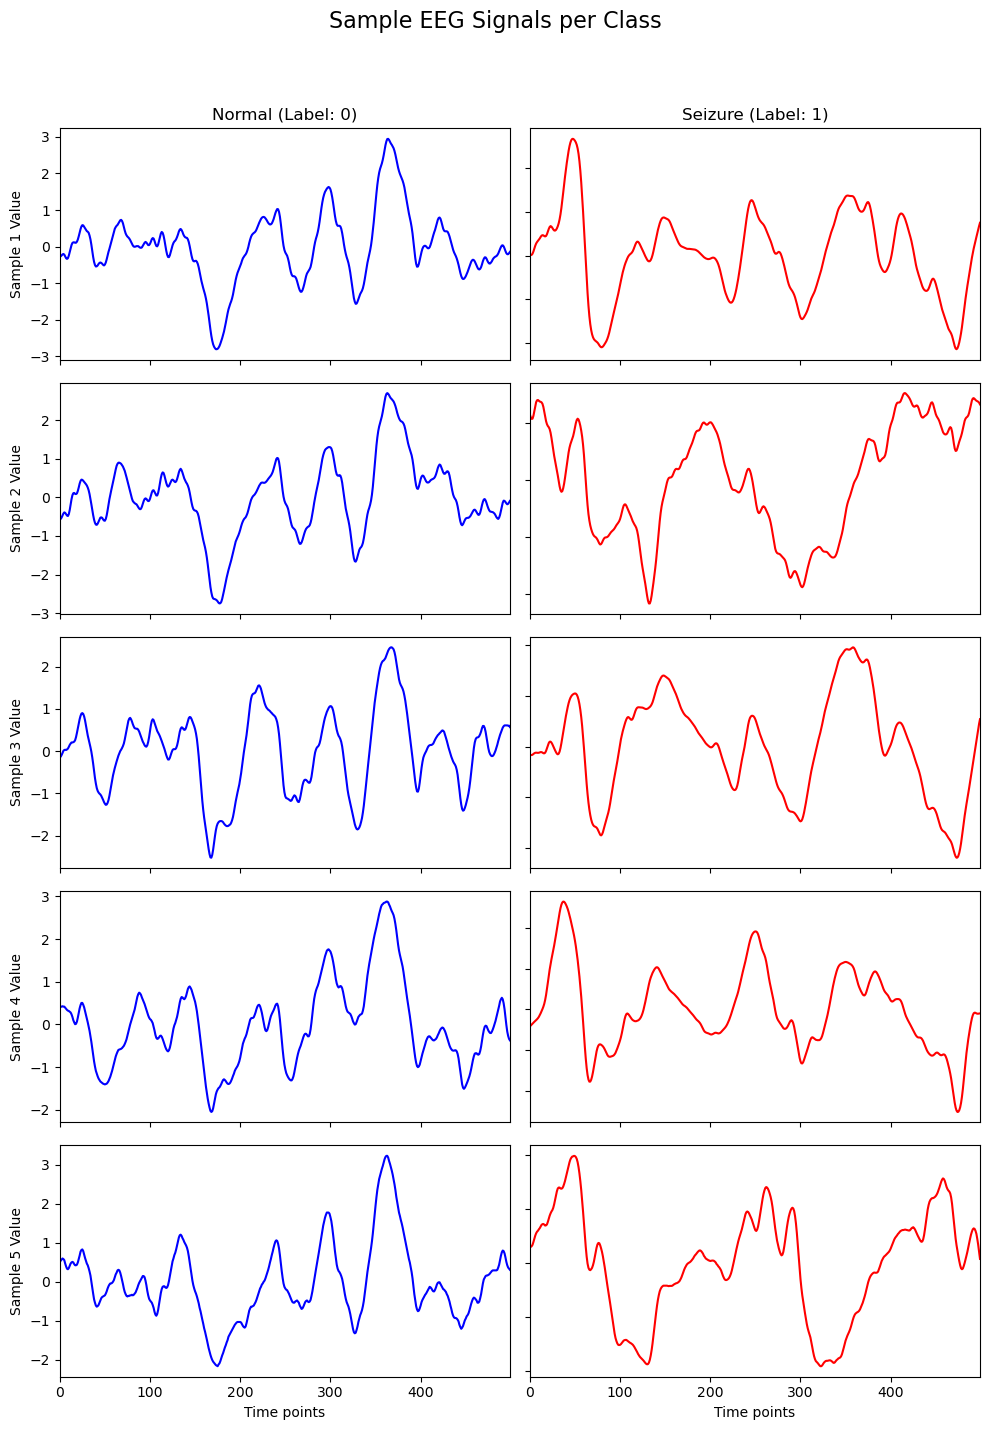

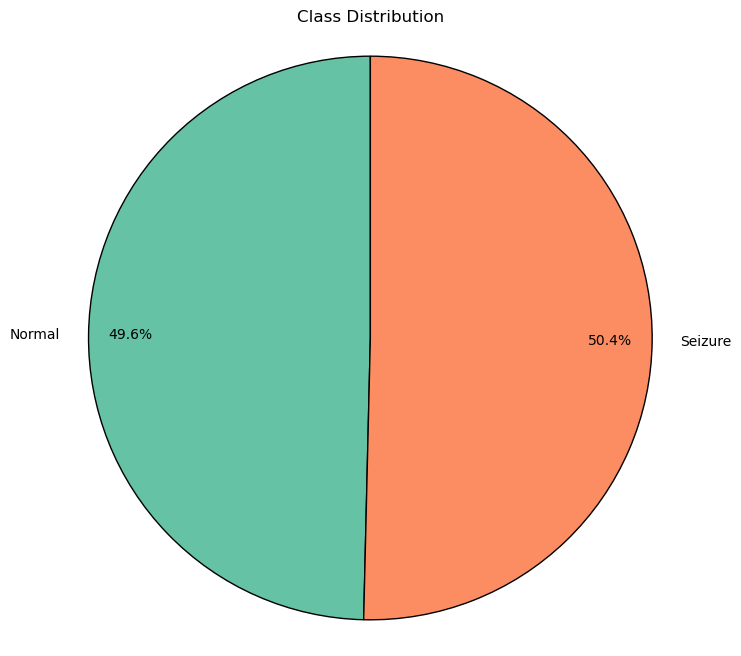

In [5]:
# CELL 6

#df_viz = data.copy()
#class_labels = {
#    0: 'no seizure',
#    1: 'seizure activity'
#}
#df_viz['y'] = df_viz['y'].map(class_labels)
#X_viz = normalize_data(df_viz, predictors)  
#y_viz, _ =  get_features_and_labels(data)  

# Assuming df_train_full, predictors are defined
# And you have defined class_labels_binary = {0: 'Normal', 1: 'Seizure'}

if 'df_train_full' in locals() and 'predictors' in locals(): # Check if necessary DataFrames are loaded
    df_viz_binary = df_train_full.copy() 

    # === DEFINE class_labels_binary HERE ===
    class_labels_binary = {
        0: 'Normal',    # Assuming 0 is Normal in your 'y' column from the CSV
        1: 'Seizure'    # Assuming 1 is Seizure in your 'y' column from the CSV
    }
    # =======================================

    # Optional: Create a string version of labels if needed by other functions,
    # but plot_class_signals (as modified) can use the numeric y and the map.
    # df_viz_binary['y_str'] = df_viz_binary['y'].map(class_labels_binary) 

    X_viz_binary = df_viz_binary[predictors] # Using your pre-Z-scored data from the CSV
    y_viz_numeric_binary = df_viz_binary['y'].values # Get the numeric 0/1 labels

    # The plot_class_signals function is imported from your modified visualization.py
    # Ensure this import is successful and visualization.py is in the correct path (e.g., ../src)
    try:
        from visualization import plot_class_signals 
        
        print(f"Plotting signals. X_viz_binary shape: {X_viz_binary.shape}, y_viz_numeric_binary unique labels: {np.unique(y_viz_numeric_binary)}")

        plot_class_signals(
            X_viz_binary, 
            y_viz_numeric_binary, 
            class_labels_map=class_labels_binary, # Pass your binary label map
            samples_per_class=5, # Or fewer, e.g., 3 or 5
            signal_length=500 # Explicitly state signal length
        )
    except ImportError:
        print("ERROR: Could not import plot_class_signals from visualization.py. Check sys.path and file location.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")

else:
    print("df_train_full or predictors not defined. Skipping signal visualization.")



plot_class_distribution(
    df_train_full, # Pass the DataFrame with numeric 'y'
    label_column='y', # Specify the numeric label column
    class_labels_map=class_labels_binary # Pass your map for names and potential colors
)

#### Compute Takens Parameters

In [6]:
# CELL 7

# Segment_Name   X1      X2      ...   X500   Label
# Train_Seg0_Ch0 0.123   0.456   ...   0.789  0
# Train_Seg0_Ch1 0.234   0.567   ...   0.890  0
# Test_Seg4_Ch18 0.345   0.678   ...   0.901  1

# The following code computes the Takens parameters with an input csv file that looks like the above comment

#Step 1: Load Data
import pandas as pd
import numpy as np

df = df_train_full.copy() 
series = df.iloc[:, 1:501].values  # Shape: (n_series, 500)
labels = df["y"].values            # Shape: (n_series,)

#Step 2: Create Balanced Subset
n_per_class = 100  # 100 seizure + 100 non-seizure

# Get indices for each class
class0_idx = np.where(labels == 0)[0]
class1_idx = np.where(labels == 1)[0]

# Randomly select 100 per class
subset_idx = np.concatenate([
    np.random.choice(class0_idx, n_per_class, replace=False),
    np.random.choice(class1_idx, n_per_class, replace=False)
])
subset_series = series[subset_idx]  # Shape: (200, 500)

#Step 3: Compute τ (Time Delay) via Mutual Information

from sklearn.metrics import mutual_info_score

def compute_mutual_info(ts, max_lag=50):
    mis = []
    for lag in range(1, max_lag + 1):
        x1 = ts[:-lag]
        x2 = ts[lag:]
        mi = mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])
        mis.append(mi)
    # Find first local minimum
    for i in range(1, len(mis) - 1):
        if mis[i] < mis[i - 1] and mis[i] < mis[i + 1]:
            return i + 1  # τ = lag index
    return 1  # Default if no minimum

# Compute τ for each series in subset
taus = [compute_mutual_info(ts) for ts in subset_series]
global_tau = int(np.median(taus))  # Median τ for all series

print(f"Time Delay (tau) computed using mutual information: {global_tau}")

#Step 4: Compute d (Embedding Dimension) via False Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

def false_nearest_neighbors(ts, tau, d_max=10, rtol=15, R_A=2.0): # Added R_A, a common FNN parameter
    n = len(ts)
    fnn_percentages = []

    # Pre-embed to maximum possible length needed for d_max
    # Max components needed = d_max + 1
    # Max length of embedded vector = (d_max) * tau (since it's (d_max-1)*tau for d_max-1 dim, and then one more tau step)
    # No, it's (d_max)*tau for the d_max dimensional vectors.
    # And (d_max+1-1)*tau = d_max*tau for the (d_max)-th component of (d_max+1) vector
    # Let's stick to your iterative embedding for now and fix the indexing.

    for d in range(1, d_max + 1): # Loop for current dimension 'd'
        # Construct d-dimensional embedding
        # Y_k = (x_k, x_{k+tau}, ..., x_{k+(d-1)tau})
        # Number of such points M = n - (d-1)*tau
        if n <= (d - 1) * tau: # Not enough points for this dimension
            fnn_percentages.append(1.0) # Indicate all are FNN or invalid
            continue
        
        embedding_d = np.array([ts[i : i + (d - 1) * tau + 1 : tau] for i in range(n - (d - 1) * tau)])
        if d == 1: # For d=1, embedding_d is (M, 1), make it (M,) for some FNN versions
            embedding_d = embedding_d.reshape(-1,1) # Ensure it's 2D for NearestNeighbors

        # Find nearest neighbors for each point in d-dimensional space
        # We only need one nearest neighbor (excluding the point itself)
        nn = NearestNeighbors(n_neighbors=2, algorithm='kd_tree')
        nn.fit(embedding_d)
        distances_d, indices_d = nn.kneighbors(embedding_d)

        # distances_d[:,1] are distances to nearest true neighbor
        # indices_d[:,1] are indices of nearest true neighbor (within embedding_d)

        # Now consider the (d+1)-th component
        # We need to check if adding x_{k+d*tau} causes a large jump
        
        num_fnn = 0
        num_valid_comparisons = 0

        for i in range(len(embedding_d)):
            neighbor_idx = indices_d[i, 1] # Index of the nearest neighbor in embedding_d

            # Check if both point i and its neighbor neighbor_idx can be extended to (d+1) dimensions
            # This means their original time series indices must allow for one more component x(t + d*tau)
            # Original time index for embedding_d[i] is 'i'
            # Original time index for embedding_d[neighbor_idx] is 'neighbor_idx'
            
            # The (d+1)-th component for point 'i' would be ts[i + d*tau]
            # The (d+1)-th component for point 'neighbor_idx' would be ts[neighbor_idx + d*tau]
            
            if (i + d * tau < n) and (neighbor_idx + d * tau < n):
                num_valid_comparisons += 1
                
                # Distance in d-dimensions (squared, to avoid sqrt initially)
                # dist_sq_d = np.sum((embedding_d[i] - embedding_d[neighbor_idx])**2)
                # Using the distance already found by NearestNeighbors is better
                dist_d_i_neighbor = distances_d[i, 1]
                if dist_d_i_neighbor == 0: # Avoid division by zero if points are identical
                    continue

                # Calculate distance in (d+1) dimensions
                # This is the squared Euclidean distance of the (d+1)th components,
                # added to the squared d-dimensional distance.
                # Or, more commonly, the ratio of the (d+1)-dim distance to d-dim distance.
                
                # Let's use the Kennel et al. criteria:
                # Criterion 1: R_d(i, tau) = || Y(i+1) - Y_nn(i+1) || / || Y(i) - Y_nn(i) || > R_tol
                # where Y(i) is d-dim, Y(i+1) is (d+1)-dim
                # This requires constructing (d+1) dim vectors and recalculating distances,
                # which is computationally more intensive than the "component-wise" check.
                
                # Your original approach was trying to compare:
                # || vectors_d1[i] - vectors_d1[neighbor_of_i_in_d_dim] || vs || vectors_d[i] - vectors_d[neighbor_of_i_in_d_dim] ||
                # The issue is `vectors_d1` is shorter.

                # Let's try to adapt your structure:
                # We need to compare point i and its d-dim neighbor (neighbor_idx)
                # *after* they are both projected to (d+1) dimensions, IF POSSIBLE.

                # Point i in (d+1) dim: ts[i : i + d*tau + 1 : tau]
                # Point neighbor_idx in (d+1) dim: ts[neighbor_idx : neighbor_idx + d*tau + 1 : tau]
                
                # This check was already done: (i + d * tau < n) and (neighbor_idx + d * tau < n)
                
                vec_i_d1 = ts[i : i + d * tau + 1 : tau]
                vec_neighbor_d1 = ts[neighbor_idx : neighbor_idx + d * tau + 1 : tau]

                dist_d1_i_neighbor = np.linalg.norm(vec_i_d1 - vec_neighbor_d1)

                if (dist_d1_i_neighbor / dist_d_i_neighbor) > rtol:
                    num_fnn += 1
                
                # Second FNN criterion (Kennel et al.): Check if (d+1)-dim distance exceeds overall attractor size
                # R_A is often standard deviation of the original time series.
                # if dist_d1_i_neighbor > R_A * np.std(ts): # This is another heuristic
                #    if not ((dist_d1_i_neighbor / dist_d_i_neighbor) > rtol): # Only count if not already FNN by first rule
                #        num_fnn += 1
                        
            # else: point i or its neighbor cannot be extended to d+1 dimensions, skip.

        if num_valid_comparisons > 0:
            fnn_percentages.append(num_fnn / num_valid_comparisons)
        else:
            fnn_percentages.append(1.0) # No valid comparisons, assume all FNN or d is too large

        # Stop if fraction drops below a threshold (e.g., 5% or 1%)
        if fnn_percentages[-1] < 0.05: # Or some other small threshold
            return d # Current dimension 'd' is good

    # If no dimension clearly drops FNN below threshold, return the one with minimum FNN percentage
    if not fnn_percentages: # Should not happen if d_max >= 1
        return 1 
    min_fnn_idx = np.argmin(fnn_percentages)
    return min_fnn_idx + 1 # Dimensions are 1-indexed

# Compute d for each series using global_tau
d_vals = [false_nearest_neighbors(ts, global_tau) for ts in subset_series]
global_d = int(np.median(d_vals))  # Median d for all series

print(f"Embedding dimension (d) computed using false nearest neighbors: {global_d}")

Time Delay (tau) computed using mutual information: 16
Embedding dimension (d) computed using false nearest neighbors: 3


In [7]:
# CELL 8

#df_train = data.copy()
#df_train[predictors] = normalize_data(df_train, predictors)

# Assuming df_train_full and predictors are defined from the modified cell [4]

# Redefine df_train and reconsider initial normalization ===
if 'df_train_full' in locals():
    df_train = df_train_full.copy() # This df_train will be used by feature extractors

    # Your CSV data is already per-segment Z-score normalized.
    # The original notebook's normalize_data (row-wise MinMax) is likely redundant
    # or counterproductive, as subsequent feature engineering steps (like FeatureExtractor.get_baseline
    # or get_features_and_labels within the TDA pipeline) will apply their own column-wise StandardScaler.

    # HENCE remove the initial normalize_data call entirely (RECOMMENDED)
    # Let the StandardScaler in feature_engineering.py be the primary scaler if needed.
    print("df_train created. Initial row-wise MinMax scaling (normalize_data from the old notebbok) from original notebook is SKIPPED.")
    print("Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).")

df_train created. Initial row-wise MinMax scaling (normalize_data from the old notebbok) from original notebook is SKIPPED.
Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).


## Bottleneck distances (H1)

### Note: Here are the class labels

In [8]:
# CELL 9

#CLASS_LABELS = {
#    5: 'eyes open',
#    4: 'eyes closed',
#    3: 'tumor region identified',
#    2: 'EEG from tumor area',
#    1: 'seizure activity'
#}

# Update CLASS_LABELS for binary classification ===
# This should be consistent with class_labels_binary defined earlier for visualization,
# and used by any functions that might rely on a global CLASS_LABELS.
CLASS_LABELS = {
    0: 'Normal',    # Assuming 0 is Normal in your 'y' column
    1: 'Seizure'    # Assuming 1 is Seizure in your 'y' column
}
print(f"Global CLASS_LABELS set to: {CLASS_LABELS}")

Global CLASS_LABELS set to: {0: 'Normal', 1: 'Seizure'}


**ONLY RUN THE NEXT CELL IF THE PERSISTENCE DIAGRAMS HAVEN"T BEEN COMPUTED AND SAVED BEFORE**

this will take lots of time to finish (it takes at least 8 hours on my machine)

the persistence diagrams should be saved in the "tda_outputs" folder (this folder is located in the same folder where this notebook is)

In [10]:
# CELL 10

# RUNNING THIS CELL IS NOW PARALLELIZED AND SHOULD BE SIGNIFICANTLY FASTER.
# Estimated runtime will be roughly (8-12 hours / number of CPU cores), plus some overhead.

from tda_distances import compute_takens_persistence_diagrams_in_parallel

if 'df_train' in locals() and 'predictors' in locals() and 'target' in locals():
    
    # These parameters are computed in a previous cell
    takens_embedding_dim = global_d
    takens_time_delay = global_tau
    ripser_max_homology_dim = 1
    
    # Decide how many cores to use. -2 is a safe default.
    # Use 1 for debugging to run without parallelism.
    num_cores_for_tda = -2 

    print(f"Attempting to compute persistence diagrams using Takens' embedding with dim={takens_embedding_dim}, delay={takens_time_delay}...")

    diagrams_takens, labels_takens = compute_takens_persistence_diagrams_in_parallel(
        dataframe=df_train, 
        predictor_columns=predictors,
        target_column=target,
        id_column='Unnamed', # Explicitly specify your ID column name
        embedding_dim=takens_embedding_dim,
        time_delay=takens_time_delay,
        max_homology_dim=ripser_max_homology_dim,
        n_cores=num_cores_for_tda # Pass the number of cores to use
    )
    
    print(f"\nComputed {len(diagrams_takens)} Takens-based diagram sets.")
    # Example: Inspect the first computed diagram set and its label
    if diagrams_takens:
        # Note: The keys in the dict will be the series_id from the 'Unnamed' column
        first_key = list(diagrams_takens.keys())[0]
        print(f"\nDiagrams for series ID '{first_key}':")
        for dim, dgm_array in diagrams_takens[first_key].items():
            print(f"  H{dim} diagram shape: {dgm_array.shape}")
        print(f"Label for series ID '{first_key}': {labels_takens[first_key]}")
else:
    print("df_train, predictors, or target not defined. Skipping diagram computation.")


# In your notebook cell for saving to Parquet

import pandas as pd
import numpy as np
import os
import gc # Import the Garbage Collector

# ==============================================================================
# --- FIX: Import PyArrow at the top of the cell ---
# ==============================================================================
# This ensures the 'pa' and 'pq' aliases are defined before they are used.
try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    print("PyArrow libraries imported successfully.")
except ImportError:
    print("ERROR: pyarrow is not installed. Please run 'pip install pyarrow' or 'conda install pyarrow'.")
    raise # Stop execution if the required library is missing
# ==============================================================================


# --- 1. Configuration ---
output_dir = "tda_outputs_parquet"
os.makedirs(output_dir, exist_ok=True)
diagrams_parquet_path = os.path.join(output_dir, "diagrams_takens.parquet")
labels_parquet_path = os.path.join(output_dir, "labels_takens.parquet")
CHUNK_SIZE = 10000 

# --- 2. Check if the input data exists ---
if 'diagrams_takens' not in locals() or 'labels_takens' not in locals():
    print("ERROR: 'diagrams_takens' or 'labels_takens' not found. Please run the TDA computation cell first.")
else:
    print(f"Preparing to save {len(diagrams_takens)} diagram sets and {len(labels_takens)} labels to Parquet format.")

    # --- 3. Process and Save Diagrams in Chunks ---
    print(f"\nProcessing diagrams for Parquet in chunks of {CHUNK_SIZE} series...")
    
    diagram_rows_chunk = []
    series_processed_count = 0
    parquet_writer = None

    for series_id, dgm_set in diagrams_takens.items():
        for hom_dim, dgm_array in dgm_set.items():
            if isinstance(dgm_array, np.ndarray) and dgm_array.ndim == 2 and dgm_array.shape[0] > 0:
                for birth, death in dgm_array:
                    diagram_rows_chunk.append({
                        'series_id': series_id, 'homology_dim': hom_dim,
                        'birth': birth, 'death': death
                    })
        
        series_processed_count += 1

        if (series_processed_count % CHUNK_SIZE == 0) or (series_processed_count == len(diagrams_takens)):
            if not diagram_rows_chunk:
                continue

            print(f"  Processed {series_processed_count}/{len(diagrams_takens)} series. Writing chunk to Parquet...")
            
            df_chunk = pd.DataFrame(diagram_rows_chunk)
            # Now 'pa' is defined and this line will work
            table_chunk = pa.Table.from_pandas(df_chunk)
            
            if parquet_writer is None:
                # The writer is created with the schema from the first chunk's table
                parquet_writer = pq.ParquetWriter(diagrams_parquet_path, table_chunk.schema, compression='snappy')
            
            parquet_writer.write_table(table_chunk)
            
            # Free up memory
            diagram_rows_chunk.clear()
            del df_chunk
            del table_chunk
            gc.collect()

    # Finalize the Parquet file
    if parquet_writer:
        parquet_writer.close()
        print(f"\nSuccessfully saved all diagram chunks to: {diagrams_parquet_path}")

    # --- 4. Process and Save Labels ---
    print(f"\nProcessing labels for Parquet...")
    if labels_takens:
        df_labels = pd.DataFrame(list(labels_takens.items()), columns=['series_id', 'label'])
        df_labels.to_parquet(labels_parquet_path, engine='pyarrow', index=False)
        print(f"Successfully saved labels to: {labels_parquet_path}")
    else:
        print("WARNING: The labels dictionary is empty.")

Attempting to compute persistence diagrams using Takens' embedding with dim=3, delay=16...
Prepared 133209 tasks for parallel TDA computation.
Starting parallel computation on 7 cores...


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   


Parallel computation finished.
Finished aggregating results. Successfully computed diagrams for 133209 series.

Computed 133209 Takens-based diagram sets.

Diagrams for series ID 'Train_Seg0_Ch0':
  H0 diagram shape: (468, 2)
  H1 diagram shape: (40, 2)
Label for series ID 'Train_Seg0_Ch0': 1
PyArrow libraries imported successfully.
Preparing to save 133209 diagram sets and 133209 labels to Parquet format.

Processing diagrams for Parquet in chunks of 10000 series...
  Processed 10000/133209 series. Writing chunk to Parquet...
  Processed 20000/133209 series. Writing chunk to Parquet...
  Processed 30000/133209 series. Writing chunk to Parquet...
  Processed 40000/133209 series. Writing chunk to Parquet...
  Processed 50000/133209 series. Writing chunk to Parquet...
  Processed 60000/133209 series. Writing chunk to Parquet...
  Processed 70000/133209 series. Writing chunk to Parquet...
  Processed 80000/133209 series. Writing chunk to Parquet...
  Processed 90000/133209 series. Writin

### LOAD THE SAVED FILES CONTAINING THE PDs COMPUTED FOR EACH TIME SERIES

In [9]:
# CELL 11

# load the precomputed TDA files into memory

# In your notebook cell for loading TDA data

import pandas as pd
import numpy as np
import os
import time
import gc # Import the Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet files are saved
parquet_output_dir = "tda_outputs_parquet" 

# Define the full paths to your Parquet files
diagrams_parquet_path = os.path.join(parquet_output_dir, "diagrams_takens.parquet")
labels_parquet_path = os.path.join(parquet_output_dir, "labels_takens.parquet")

# --- 2. Initialize Global Variables ---
# These will hold the final dictionary structures
DIAGRAMS_TAKENS_GLOBAL = None
LABELS_TAKENS_GLOBAL = None

print(f"Attempting to load TDA data from Parquet files and reconstruct dictionaries...")
start_time = time.time()

try:
    # --- 3. Load the Parquet files into temporary DataFrames ---
    print(f"  Loading diagrams DataFrame from: {diagrams_parquet_path}")
    df_diagrams = pd.read_parquet(diagrams_parquet_path, engine='pyarrow')
    
    print(f"  Loading labels DataFrame from: {labels_parquet_path}")
    df_labels = pd.read_parquet(labels_parquet_path, engine='pyarrow')
    
    print(f"  Parquet files loaded in {time.time() - start_time:.2f} seconds.")

    # --- 4. Reconstruct the Labels Dictionary (LABELS_TAKENS_GLOBAL) ---
    print("\n  Reconstructing labels dictionary...")
    reconstruction_start_time = time.time()
    
    LABELS_TAKENS_GLOBAL = df_labels.set_index('series_id')['label'].to_dict()
    
    print(f"    -> Done in {time.time() - reconstruction_start_time:.2f} seconds. {len(LABELS_TAKENS_GLOBAL)} labels reconstructed.")

    # --- 5. Reconstruct the Nested Diagrams Dictionary (DIAGRAMS_TAKENS_GLOBAL) ---
    print("\n  Reconstructing nested diagrams dictionary (this may take a moment)...")
    reconstruction_start_time = time.time()
    
    DIAGRAMS_TAKENS_GLOBAL = {}
    
    # Grouping by 'series_id' is the most efficient way to process this
    for series_id, group_df in df_diagrams.groupby('series_id'):
        series_diagrams = {}
        for hom_dim, dim_df in group_df.groupby('homology_dim'):
            series_diagrams[hom_dim] = dim_df[['birth', 'death']].to_numpy()
        DIAGRAMS_TAKENS_GLOBAL[series_id] = series_diagrams
        
    print(f"    -> Done in {time.time() - reconstruction_start_time:.2f} seconds. {len(DIAGRAMS_TAKENS_GLOBAL)} diagram sets reconstructed.")

    # ==============================================================================
    # --- 6. Explicit Memory Cleanup (The New Step) ---
    # ==============================================================================
    print("\n  Releasing memory from intermediate DataFrames...")
    
    # Delete the DataFrame variables. This removes the references to the large
    # objects in memory.
    del df_diagrams
    del df_labels
    
    # Trigger the garbage collector to immediately reclaim the memory if possible.
    # While Python's reference counting often handles this automatically, an explicit
    # call can be useful after deleting very large objects.
    collected_count = gc.collect()
    print(f"    -> Garbage collector freed {collected_count} objects.")
    # ==============================================================================

    # --- 7. Final Verification ---
    total_time = time.time() - start_time
    print(f"\n--- Data Loading and Dictionary Reconstruction Complete in {total_time:.2f}s ---")
    
    if DIAGRAMS_TAKENS_GLOBAL:
        first_key = list(DIAGRAMS_TAKENS_GLOBAL.keys())[0]
        print(f"\nVerification for first series ID '{first_key}':")
        print(f"  Label: {LABELS_TAKENS_GLOBAL.get(first_key)}")
        print(f"  Diagrams:")
        for dim, dgm_array in DIAGRAMS_TAKENS_GLOBAL[first_key].items():
            print(f"    H{dim} diagram shape: {dgm_array.shape}")

except FileNotFoundError:
    print(f"\nERROR: One or both Parquet files not found. Please check the paths.")
    DIAGRAMS_TAKENS_GLOBAL = None
    LABELS_TAKENS_GLOBAL = None
except Exception as e:
    print(f"\nAn unexpected error occurred during loading or reconstruction: {e}")
    DIAGRAMS_TAKENS_GLOBAL = None
    LABELS_TAKENS_GLOBAL = None
    # Optionally, clean up any partially loaded dataframes in case of error
    if 'df_diagrams' in locals(): del df_diagrams
    if 'df_labels' in locals(): del df_labels
    gc.collect()
    # raise e # Re-raise the exception after cleanup

Attempting to load TDA data from Parquet files and reconstruct dictionaries...
  Loading diagrams DataFrame from: tda_outputs_parquet/diagrams_takens.parquet
  Loading labels DataFrame from: tda_outputs_parquet/labels_takens.parquet
  Parquet files loaded in 5.40 seconds.

  Reconstructing labels dictionary...
    -> Done in 0.03 seconds. 133209 labels reconstructed.

  Reconstructing nested diagrams dictionary (this may take a moment)...
    -> Done in 122.04 seconds. 133209 diagram sets reconstructed.

  Releasing memory from intermediate DataFrames...
    -> Garbage collector freed 0 objects.

--- Data Loading and Dictionary Reconstruction Complete in 127.74s ---

Verification for first series ID 'Train_Seg0_Ch0':
  Label: 1
  Diagrams:
    H0 diagram shape: (468, 2)
    H1 diagram shape: (40, 2)


### Automated Parameter Selection for Persistence Images

In [10]:
# CELL 12

# === Automated PI Parameter Selection from Parquet Files ===
# In a new notebook cell, AFTER the cell that loads data into DIAGRAMS_TAKENS_GLOBAL

import numpy as np
import os
import matplotlib.pyplot as plt
from persim import PersistenceImager # Ensure this is imported

# --- 1. Configuration ---
# This cell now depends on the global dictionary loaded previously.
HOMOLOGY_DIM_TO_ANALYZE = 1
# Percentiles for robust range estimation
LOW_PERCENTILE_BIRTH = 1.0
HIGH_PERCENTILE_BIRTH = 99.0
LOW_PERCENTILE_PERS = 0.0
HIGH_PERCENTILE_PERS = 99.0
# Target PI Resolution
TARGET_PI_RESOLUTION_APPROX = 20
DEFAULT_SPAN = 0.1
# --- End Configuration ---

print("\n--- Automated Persistence Imager Parameter Selection from In-Memory Diagrams ---")

# --- 2. Check for In-Memory Data and Process ---
auto_pi_params = None
auto_pi_shape = None

if 'DIAGRAMS_TAKENS_GLOBAL' not in locals() or DIAGRAMS_TAKENS_GLOBAL is None:
    print("ERROR: Global dictionary 'DIAGRAMS_TAKENS_GLOBAL' not found or is empty. Please run the data loading cell first.")
else:
    all_births = []
    all_persistences = []

    print(f"Extracting H{HOMOLOGY_DIM_TO_ANALYZE} points from {len(DIAGRAMS_TAKENS_GLOBAL)} diagram sets in memory...")
    
    # Iterate directly through the in-memory dictionary
    for series_id, diagram_set in DIAGRAMS_TAKENS_GLOBAL.items():
        dgm = diagram_set.get(HOMOLOGY_DIM_TO_ANALYZE)
        
        if dgm is not None and isinstance(dgm, np.ndarray) and dgm.ndim == 2 and dgm.shape[0] > 0:
            # Filter out infinite death points, which can exist for H0
            finite_death_mask = np.isfinite(dgm[:, 1])
            dgm_finite = dgm[finite_death_mask]

            if dgm_finite.shape[0] > 0:
                birth_points = dgm_finite[:, 0]
                persistence_points = dgm_finite[:, 1] - birth_points
                
                # Filter out any negative persistences from floating point issues
                valid_persistence_mask = persistence_points >= 0
                
                all_births.extend(birth_points[valid_persistence_mask])
                all_persistences.extend(persistence_points[valid_persistence_mask])

    if not all_births:
        print(f"ERROR: No valid H{HOMOLOGY_DIM_TO_ANALYZE} diagram points found to analyze.")
    else:
        all_births = np.array(all_births)
        all_persistences = np.array(all_persistences)
        print(f"Total H{HOMOLOGY_DIM_TO_ANALYZE} points analyzed: {len(all_births)}")

        # --- 3. Automated Determination of Parameters (Logic is unchanged) ---
        
        # Determine birth_range
        min_birth_val = np.percentile(all_births, LOW_PERCENTILE_BIRTH)
        max_birth_val = np.percentile(all_births, HIGH_PERCENTILE_BIRTH)
        if np.all(all_births >= 0): min_birth_val = max(0.0, min_birth_val)
        if max_birth_val <= min_birth_val: max_birth_val = min_birth_val + DEFAULT_SPAN
        auto_birth_range = (min_birth_val, max_birth_val)
        print(f"Determined birth_range: ({auto_birth_range[0]:.3f}, {auto_birth_range[1]:.3f})")

        # Determine pers_range
        min_pers_val = np.percentile(all_persistences, LOW_PERCENTILE_PERS)
        max_pers_val = np.percentile(all_persistences, HIGH_PERCENTILE_PERS)
        min_pers_val = max(0.0, min_pers_val)
        if max_pers_val <= min_pers_val: max_pers_val = min_pers_val + DEFAULT_SPAN
        auto_pers_range = (min_pers_val, max_pers_val)
        print(f"Determined pers_range: ({auto_pers_range[0]:.3f}, {auto_pers_range[1]:.3f})")

        # Determine pixel_size
        birth_span = auto_birth_range[1] - auto_birth_range[0]
        pers_span = auto_pers_range[1] - auto_pers_range[0]
        if birth_span <= 0: birth_span = DEFAULT_SPAN
        if pers_span <= 0: pers_span = DEFAULT_SPAN
        longer_span = max(birth_span, pers_span)
        auto_pixel_size = longer_span / TARGET_PI_RESOLUTION_APPROX
        if auto_pixel_size <= 1e-6: auto_pixel_size = 0.01
        print(f"Calculated pixel_size: {auto_pixel_size:.4f}")

        # Consolidate parameters
        auto_pi_params = {
            'birth_range': auto_birth_range,
            'pers_range': auto_pers_range,
            'pixel_size': auto_pixel_size,
        }

        # Dynamically determine the exact PI shape by instantiating a temporary imager
        temp_pim = PersistenceImager(**auto_pi_params)
        
        # Create a valid dummy point to get the shape without errors
        safe_b = auto_birth_range[0]
        safe_d = auto_birth_range[0] + auto_pers_range[0]
        dummy_dgm = np.array([[safe_b, safe_d]])
        
        auto_pi_shape = temp_pim.transform(dummy_dgm).shape
        print(f"Dynamically determined auto_pi_shape: {auto_pi_shape}")

# --- Final Check ---
print("\n--- Final values from Automated PI Parameter Selection Cell ---")
if auto_pi_params is not None:
    print(f"Final auto_pi_params: {auto_pi_params}")
    print(f"Final auto_pi_shape: {auto_pi_shape}")
    print(f"Final HOMOLOGY_DIM_TO_ANALYZE: {HOMOLOGY_DIM_TO_ANALYZE}")
else:
    print("PI parameter automation failed. Downstream cells will not work.")


--- Automated Persistence Imager Parameter Selection from In-Memory Diagrams ---
Extracting H1 points from 133209 diagram sets in memory...
Total H1 points analyzed: 9101855
Determined birth_range: (0.051, 1.279)
Determined pers_range: (0.000, 1.161)
Calculated pixel_size: 0.0614
Dynamically determined auto_pi_shape: (20, 18)

--- Final values from Automated PI Parameter Selection Cell ---
Final auto_pi_params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
Final auto_pi_shape: (20, 18)
Final HOMOLOGY_DIM_TO_ANALYZE: 1


In [11]:
# === CELL D (Revised): Create Feature Methods Dictionary ===

from feature_engineering import get_extractors_methods
import os

# --- Configuration ---
# Point to the directory containing the PARQUET files
PARQUET_OUTPUT_DIR = "tda_outputs_parquet" 
SAVED_DIAGRAMS_PATH_PARQUET = os.path.join(PARQUET_OUTPUT_DIR, "diagrams_takens.parquet")
SAVED_LABELS_PATH_PARQUET = os.path.join(PARQUET_OUTPUT_DIR, "labels_takens.parquet")

print("\n--- Initializing FeatureExtractor with Parquet paths and Auto-PI Parameters ---")

# --- Check if parameters from previous cell are available ---
if 'auto_pi_params' in locals() and auto_pi_params is not None and \
   'auto_pi_shape' in locals() and auto_pi_shape is not None and \
   'HOMOLOGY_DIM_TO_ANALYZE' in locals():
    
    print("Using automatically determined PI parameters from the previous cell.")
    
    # The pi_config should be a clean dictionary for the PersistenceImager constructor
    pi_config_for_feature_extractor = auto_pi_params.copy()

    # The get_extractors_methods function will pass these parameters to the FeatureExtractor
    feature_methods = get_extractors_methods(
        scale=True, 
        diagrams_path=SAVED_DIAGRAMS_PATH_PARQUET, # Pass PARQUET path
        labels_path=SAVED_LABELS_PATH_PARQUET,   # Pass PARQUET path
        pi_params=pi_config_for_feature_extractor,
        pi_hom_dim=HOMOLOGY_DIM_TO_ANALYZE,
        pi_shape_tuple=auto_pi_shape 
    )
    print("\n`feature_methods` dictionary created successfully.")
    print(f"  FeatureExtractor is now configured to load TDA data from:\n    - {SAVED_DIAGRAMS_PATH_PARQUET}\n    - {SAVED_LABELS_PATH_PARQUET}")

else:
    print("ERROR: Essential PI parameters from the previous cell are missing. Cannot create feature_methods.")
    # You might want to raise an error here to halt execution
    # raise ValueError("auto_pi_params, auto_pi_shape, or HOMOLOGY_DIM_TO_ANALYZE not defined.")


--- Initializing FeatureExtractor with Parquet paths and Auto-PI Parameters ---
Using automatically determined PI parameters from the previous cell.
FeatureExtractor initialized. TDA configured to use Parquet path: tda_outputs_parquet/diagrams_takens.parquet
PersistenceImager params to be used: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}

`feature_methods` dictionary created successfully.
  FeatureExtractor is now configured to load TDA data from:
    - tda_outputs_parquet/diagrams_takens.parquet
    - tda_outputs_parquet/labels_takens.parquet


In [12]:
# TESTING CELL
# In your NEW notebook cell for testing TDA feature extraction
if 'feature_methods' in locals() and 'df_train' in locals():
    print("\n--- Testing TDA feature extraction directly ---")
    sample_indices = df_train.index[:5] 
    sample_df = df_train.loc[sample_indices]
    
    print(f"Sample DataFrame for testing (shape {sample_df.shape}):")
    # print(sample_df.head()) # Keep this if you want to see the sample data

    tda_extractor_func = feature_methods.get("TDA")
    if tda_extractor_func:
        try:
            print("Calling TDA extractor function on sample...")
            y_sample_pi, X_sample_pi = tda_extractor_func(sample_df) # This calls FeatureExtractor.get_tda
            
            print(f"Output y_sample_pi shape: {y_sample_pi.shape if y_sample_pi is not None else 'None'}")
            print(f"Output X_sample_pi shape: {X_sample_pi.shape if X_sample_pi is not None else 'None'}")
            
            if X_sample_pi is not None and X_sample_pi.shape[0] > 0:
                # === MODIFIED TO USE auto_pi_shape ===
                # auto_pi_shape should be defined from Cell C
                if 'auto_pi_shape' in locals() and auto_pi_shape is not None:
                    expected_pi_vector_length = auto_pi_shape[0] * auto_pi_shape[1]
                    print(f"Expected PI vector length (from auto_pi_shape {auto_pi_shape}): {expected_pi_vector_length}")
                    print(f"Actual PI vector length: {X_sample_pi.shape[1]}")
                    if X_sample_pi.shape[1] != expected_pi_vector_length:
                        print("WARNING: PI vector length mismatch with auto_pi_shape!")
                    # Additionally, let's check against the pi_shape passed to the extractor if available
                    # This requires FeatureExtractor to store self.pi_shape which it does.
                    # However, tda_extractor_func is just the method, not the instance.
                    # So auto_pi_shape is the most direct check here from notebook global scope.
                else:
                    print("Warning: 'auto_pi_shape' not found in global scope for verification. Cannot verify PI vector length.")
        except Exception as e:
            print(f"Error during direct test call to TDA extractor: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for better debugging
    else:
        print("TDA extractor function not found in feature_methods.")
else:
    print("feature_methods or df_train not defined. Skipping direct test.")


--- Testing TDA feature extraction directly ---
Sample DataFrame for testing (shape (5, 502)):
Calling TDA extractor function on sample...
Output y_sample_pi shape: (5,)
Output X_sample_pi shape: (5, 360)
Expected PI vector length (from auto_pi_shape (20, 18)): 360
Actual PI vector length: 360


## Computing Statistics Concerning Bottleneck Distance between Persistence Diagrams

The next notebook cell computes bottleneck distances between persistence diagrams to analyze topological differences within and between different classes of time series data. This enables quantitative comparison of topological features extracted from different signal types.

## Key Components

### 1. Configuration & Setup
- Configures analysis parameters including:
  - Homology dimension (H1 by default)
  - Random seeds for reproducibility
  - Parallel processing cores
  - Output file paths with timestamps
- Defines three main analysis tasks:
  - **Within-class distances for seizure data** (class 1)
  - **Within-class distances for normal data** (class 0) 
  - **Between-class distances** (seizure vs. normal)

### 2. Data Processing Pipeline
- Loads pre-computed persistence diagrams and labels from global variables (`DIAGRAMS_TAKENS_GLOBAL`, `LABELS_TAKENS_GLOBAL`)
- Validates data integrity and consistency
- Extracts valid diagrams for specified classes and homology dimensions
- Implements robust error handling for malformed diagrams

### 3. Intelligent Sampling Strategies

The code uses adaptive sampling approaches based on dataset size to balance computational efficiency with statistical accuracy:

#### Method A (Small Datasets): N < 5,000 diagrams
- Generates all possible diagram pairs using `itertools.combinations`
- Samples uniformly from the complete set of pairs
- Ensures truly uniform sampling from all possible combinations
- Computationally feasible for smaller datasets

#### Method C (Large Datasets): N ≥ 5,000 diagrams  
- Uses iterative sampling to avoid memory limitations
- Samples pairs with replacement to approximate uniform distribution
- Prevents memory overflow issues with large datasets
- Maintains statistical validity through random sampling

### 4. Parallel Distance Computation
- Computes bottleneck distances between sampled diagram pairs using parallel processing
- Utilizes `joblib.Parallel` with configurable core allocation
- Implements robust error handling for individual pair computations
- Filters out invalid results (NaN values) from failed computations
- Tracks computation timing and success rates

### 5. Statistical Analysis & Reporting
- Calculates comprehensive summary statistics:
  - Central tendency: mean, median
  - Variability: standard deviation, IQR
  - Range: min, max, quartiles
- Tracks important metadata:
  - Number of valid diagrams per class
  - Number of pairs sampled
  - Number of successful distance computations
- Exports results to timestamped CSV files for reproducible analysis

## Detailed Workflow

### Step 1: Data Loading & Validation
```python
# Loads and verifies global persistence diagram data
all_diagrams_global, all_labels_global = load_and_verify_data_from_globals()
```

### Step 2: Class-Specific Diagram Extraction
```python
# Extracts valid H1 diagrams for target class
diagrams_A_full_class = get_all_valid_diagrams_for_class(
    all_diagrams_global, all_labels_global, target_class, homology_dim
)
```

### Step 3: Adaptive Pair Sampling
- **Intra-class**: Samples pairs from within the same class
- **Inter-class**: Samples pairs across different classes
- Automatically selects optimal sampling method based on dataset size

### Step 4: Parallel Distance Computation
```python
# Computes bottleneck distances using multiple cores
finite_distances = compute_distances_for_given_pairs_parallel(
    sampled_pairs, n_cores, task_name
)
```

### Step 5: Statistical Summary & Export
- Generates comprehensive statistics for each analysis task
- Combines results across all tasks
- Exports to CSV with timestamp for version control


## Output Format

The analysis generates a comprehensive CSV report containing:
- Task identification and parameters
- Sample size information
- Statistical summaries (mean, median, std dev, quartiles)
- Quality metrics (success rates, error counts)
- Timestamp for version control

### ONLY RUN THE FOLLOWING CELL IF YOU HAVE NOT COMPUTED THE SATATISTICS CONCERNING BOTTLENECK DISTANCE

In [13]:
# CELL 13

# JUST NEED TO RUN THIS ONCE

import numpy as np
import pandas as pd
import itertools
import time
import os
import datetime
from tda_distances import bottleneck_distance
from joblib import Parallel, delayed
import random

# --- I. Global Configuration Block ---
print("--- Bottleneck Distance Analysis (Revised Sampling) Configuration ---")

# These global dictionaries must be loaded from your .joblib files in a PREVIOUS cell.
# DIAGRAMS_TAKENS_GLOBAL = joblib.load("tda_outputs/diagrams_takens.joblib")
# LABELS_TAKENS_GLOBAL = joblib.load("tda_outputs/labels_takens.joblib")

HOMOLOGY_DIM_FOR_DISTANCE = 1
SEED_FOR_SAMPLING = 42
N_CORES_TO_USE = max(1, os.cpu_count() - 2 if os.cpu_count() > 2 else 1)
INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A = 10000

tasks_to_run = [
    {
        'name': f"Within-Class Seizure (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'within-class', 
        'class_label_A': 1, 'num_pairs_to_sample_k': 10000, # Reduced k for faster test run
        'class_label_B': None
    },
    {
        'name': f"Within-Class Normal (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'within-class', 
        'class_label_A': 0, 'num_pairs_to_sample_k': 10000, # Reduced k for faster test run
        'class_label_B': None
    },
    {
        'name': f"Between Seizure(1)-Normal(0) (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'between-class', 
        'class_label_A': 1, 'class_label_B': 0, 
        'num_pairs_to_sample_k': 10000 # Reduced k for faster test run
    },
]

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_STATS_FILENAME = f"bottleneck_distance_stats_revised_sampling_{timestamp}.csv"
OUTPUT_STATS_DIR = "metrics"
os.makedirs(OUTPUT_STATS_DIR, exist_ok=True)
output_stats_filepath = os.path.join(OUTPUT_STATS_DIR, OUTPUT_STATS_FILENAME)

print(f"Homology Dimension for Distances: H{HOMOLOGY_DIM_FOR_DISTANCE}")
print(f"Seed for Overall Sampling Choices: {SEED_FOR_SAMPLING}")
print(f"Cores for Parallelization: {N_CORES_TO_USE}")
print(f"Intra-class N_threshold for Method A (all pairs generation): {INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A}")
print(f"Output statistics file will be: {output_stats_filepath}")
print(f"Tasks to run: {len(tasks_to_run)}")
for i, task in enumerate(tasks_to_run):
    print(f"  Task {i+1}: {task['name']}, k_pairs={task['num_pairs_to_sample_k']}")
print("-" * 60)

# --- II. Core Function Definitions (Helper Functions) ---

def load_and_verify_data_from_globals():
    if 'DIAGRAMS_TAKENS_GLOBAL' not in globals() or DIAGRAMS_TAKENS_GLOBAL is None:
        raise NameError("DIAGRAMS_TAKENS_GLOBAL not found or not loaded.")
    if 'LABELS_TAKENS_GLOBAL' not in globals() or LABELS_TAKENS_GLOBAL is None:
        raise NameError("LABELS_TAKENS_GLOBAL not found or not loaded.")
    
    print(f"Accessed global diagrams ({len(DIAGRAMS_TAKENS_GLOBAL)}) and labels ({len(LABELS_TAKENS_GLOBAL)}).")
    return DIAGRAMS_TAKENS_GLOBAL, LABELS_TAKENS_GLOBAL

def get_all_valid_diagrams_for_class(all_diagrams_global, all_labels_global, 
                                     target_label, homology_dim):
    """Extracts all valid diagrams for a specific class and homology dimension."""
    print(f"    Extracting all valid H{homology_dim} diagrams for Class Label '{target_label}'...")
    class_specific_series_ids = [
        sid for sid, label in all_labels_global.items() 
        if label == target_label and sid in all_diagrams_global
    ]
    
    N_total_for_class = len(class_specific_series_ids)
    print(f"      Found {N_total_for_class} total series for class '{target_label}'.")

    valid_diagrams = []
    if N_total_for_class > 0:
        for series_id in class_specific_series_ids:
            diagram_set = all_diagrams_global.get(series_id)
            if diagram_set:
                dgm = diagram_set.get(homology_dim)
                if isinstance(dgm, np.ndarray) and dgm.ndim == 2 and dgm.shape[1] == 2:
                    valid_diagrams.append(dgm)
        print(f"      Extracted {len(valid_diagrams)} valid H{homology_dim} diagrams for class '{target_label}'.")
    
    # ========================== THE FIX ==========================
    # The function must return TWO values to match the calling code.
    # We return the list of diagrams AND the count of diagrams in that list.
    return valid_diagrams, len(valid_diagrams)
    # ======================= END OF FIX ========================

def sample_diagram_pairs_intra_class(diagram_list, num_pairs_to_sample_k, seed, N_threshold_method_A):
    N = len(diagram_list)
    if N < 2:
        return []

    random.seed(seed)
    np.random.seed(seed)
    sampled_diagram_pairs = []

    if N < N_threshold_method_A:
        all_possible_idx_pairs = list(itertools.combinations(range(N), 2))
        actual_k_to_sample = min(num_pairs_to_sample_k, len(all_possible_idx_pairs))
        if actual_k_to_sample == 0: return []
        sampled_idx_pairs = random.sample(all_possible_idx_pairs, actual_k_to_sample)
        for idx1, idx2 in sampled_idx_pairs:
            sampled_diagram_pairs.append((diagram_list[idx1], diagram_list[idx2]))
    else:
        indices = np.arange(N)
        for _ in range(num_pairs_to_sample_k):
            idx1, idx2 = np.random.choice(indices, size=2, replace=False)
            sampled_diagram_pairs.append((diagram_list[idx1], diagram_list[idx2]))
            
    return sampled_diagram_pairs

def sample_diagram_pairs_inter_class(diagram_list_A, diagram_list_B, num_pairs_to_sample_k, seed):
    N_A, N_B = len(diagram_list_A), len(diagram_list_B)
    if N_A == 0 or N_B == 0:
        return []
    np.random.seed(seed)
    rand_indices_A = np.random.choice(np.arange(N_A), size=num_pairs_to_sample_k, replace=True)
    rand_indices_B = np.random.choice(np.arange(N_B), size=num_pairs_to_sample_k, replace=True)
    return [(diagram_list_A[i], diagram_list_B[j]) for i, j in zip(rand_indices_A, rand_indices_B)]

def _compute_single_bottleneck_pair_worker_revised(diagram_pair_tuple):
    dgm_A, dgm_B = diagram_pair_tuple
    try:
        if not (isinstance(dgm_A, np.ndarray) and dgm_A.ndim == 2 and dgm_A.shape[1] == 2):
            dgm_A = np.array([[]]).reshape(0,2)
        if not (isinstance(dgm_B, np.ndarray) and dgm_B.ndim == 2 and dgm_B.shape[1] == 2):
            dgm_B = np.array([[]]).reshape(0,2)
        return bottleneck_distance(dgm_A, dgm_B)
    except Exception:
        return np.nan

def compute_distances_for_given_pairs_parallel(list_of_diagram_pairs, n_cores=1, task_name=""):
    num_pairs_to_compute = len(list_of_diagram_pairs)
    if num_pairs_to_compute == 0: return np.array([]), 0
    print(f"    Task '{task_name}': Preparing to compute {num_pairs_to_compute} bottleneck distances using {n_cores} cores...")
    start_time = time.time()
    computed_distances = Parallel(n_jobs=n_cores, verbose=5, backend="loky")(
        delayed(_compute_single_bottleneck_pair_worker_revised)(pair) for pair in list_of_diagram_pairs
    )
    total_time = time.time() - start_time
    print(f"    Task '{task_name}': Finished parallel computation in {total_time:.2f}s.")
    distances_array = np.array(computed_distances, dtype=float)
    return distances_array[np.isfinite(distances_array)], np.sum(np.isnan(distances_array))

def calculate_summary_statistics(distances_array, task_name, N_class_A_total_valid, N_class_B_total_valid=None, k_pairs_sampled=0):
    if distances_array is None or len(distances_array) == 0:
        return {'Task Name': task_name, 'N_Valid_Diagrams_ClassA': N_class_A_total_valid, 'N_Valid_Diagrams_ClassB': N_class_B_total_valid or 'N/A', 'K_Pairs_Sampled': k_pairs_sampled, 'Num_Distances_Successfully_Computed': 0, 'Mean': np.nan, 'Median': np.nan, 'StdDev': np.nan, 'Min': np.nan, 'Max': np.nan, 'Q1': np.nan, 'Q3': np.nan, 'IQR': np.nan}
    stats = {'Task Name': task_name, 'N_Valid_Diagrams_ClassA': N_class_A_total_valid, 'N_Valid_Diagrams_ClassB': N_class_B_total_valid or 'N/A', 'K_Pairs_Sampled': k_pairs_sampled, 'Num_Distances_Successfully_Computed': len(distances_array), 'Mean': np.mean(distances_array), 'Median': np.median(distances_array), 'StdDev': np.std(distances_array), 'Min': np.min(distances_array), 'Max': np.max(distances_array), 'Q1': np.percentile(distances_array, 25), 'Q3': np.percentile(distances_array, 75)}
    stats['IQR'] = stats['Q3'] - stats['Q1']
    return stats

def display_and_save_statistics(stats_dict_list, output_filepath):
    if not stats_dict_list: return
    stats_df = pd.DataFrame(stats_dict_list)
    column_order = ['Task Name', 'N_Valid_Diagrams_ClassA', 'N_Valid_Diagrams_ClassB', 'K_Pairs_Sampled', 'Num_Distances_Successfully_Computed', 'Mean', 'Median', 'StdDev', 'Min', 'Max', 'Q1', 'Q3', 'IQR']
    for col in column_order:
        if col not in stats_df.columns: stats_df[col] = 'N/A'
    stats_df = stats_df[column_order]
    print("\n\n--- Overall Bottleneck Distance Statistics Summary (Revised Sampling) ---")
    print(stats_df.to_string(index=False, float_format="%.6f"))
    stats_df.to_csv(output_filepath, index=False, float_format="%.6f")
    print(f"\nSuccessfully saved statistics summary to: {output_filepath}")

# --- III. Main Execution Logic ---
try:
    all_diagrams_global, all_labels_global = load_and_verify_data_from_globals()
    all_tasks_summary_stats = [] 
    np.random.seed(SEED_FOR_SAMPLING)
    random.seed(SEED_FOR_SAMPLING)

    for task_idx, task_config in enumerate(tasks_to_run):
        print(f"\n--- Running Task {task_idx+1}/{len(tasks_to_run)}: {task_config['name']} ---")
        current_task_seed = SEED_FOR_SAMPLING + task_idx 
        
        diagrams_A_full_class, N_valid_A = get_all_valid_diagrams_for_class(all_diagrams_global, all_labels_global, task_config['class_label_A'], HOMOLOGY_DIM_FOR_DISTANCE)
        sampled_diagram_pairs = []
        N_valid_B_for_stats = None 

        if task_config['type'] == 'within-class':
            if N_valid_A >= 2:
                sampled_diagram_pairs = sample_diagram_pairs_intra_class(diagrams_A_full_class, task_config['num_pairs_to_sample_k'], current_task_seed, INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A)
        elif task_config['type'] == 'between-class':
            diagrams_B_full_class, N_valid_B = get_all_valid_diagrams_for_class(all_diagrams_global, all_labels_global, task_config['class_label_B'], HOMOLOGY_DIM_FOR_DISTANCE)
            N_valid_B_for_stats = N_valid_B
            if N_valid_A > 0 and N_valid_B > 0:
                sampled_diagram_pairs = sample_diagram_pairs_inter_class(diagrams_A_full_class, diagrams_B_full_class, task_config['num_pairs_to_sample_k'], current_task_seed)

        finite_distances, _ = compute_distances_for_given_pairs_parallel(sampled_diagram_pairs, N_CORES_TO_USE, task_config['name']) if sampled_diagram_pairs else (np.array([]), 0)
        task_stats = calculate_summary_statistics(finite_distances, task_config['name'], N_valid_A, N_valid_B_for_stats, len(sampled_diagram_pairs))
        all_tasks_summary_stats.append(task_stats)
        print(f"    Summary for '{task_config['name']}':\n{pd.DataFrame([task_stats]).to_string(index=False, float_format='%.6f')}")

    display_and_save_statistics(all_tasks_summary_stats, output_stats_filepath)

except NameError as e:
    print(f"CRITICAL EXECUTION HALTED: {e}")
except FileNotFoundError as e: 
    print(f"CRITICAL EXECUTION HALTED due to FileNotFoundError: {e}")
except Exception as e:
    import traceback
    print(f"An unexpected CRITICAL error occurred: {e}")
    traceback.print_exc()

--- Bottleneck Distance Analysis (Revised Sampling) Configuration ---
Homology Dimension for Distances: H1
Seed for Overall Sampling Choices: 42
Cores for Parallelization: 6
Intra-class N_threshold for Method A (all pairs generation): 10000
Output statistics file will be: metrics/bottleneck_distance_stats_revised_sampling_20250612_192148.csv
Tasks to run: 3
  Task 1: Within-Class Seizure (H1), k_pairs=10000
  Task 2: Within-Class Normal (H1), k_pairs=10000
  Task 3: Between Seizure(1)-Normal(0) (H1), k_pairs=10000
------------------------------------------------------------
Accessed global diagrams (133209) and labels (133209).

--- Running Task 1/3: Within-Class Seizure (H1) ---
    Extracting all valid H1 diagrams for Class Label '1'...
      Found 67108 total series for class '1'.
      Extracted 67103 valid H1 diagrams for class '1'.
    Task 'Within-Class Seizure (H1)': Preparing to compute 10000 bottleneck distances using 6 cores...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done  62 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 396 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 900 tasks      | elapsed:   20.3s
[Parallel(n_jobs=6)]: Done 1548 tasks      | elapsed:   32.4s
[Parallel(n_jobs=6)]: Done 2340 tasks      | elapsed:   47.2s
[Parallel(n_jobs=6)]: Done 3276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 4356 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 5580 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 6948 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 8460 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 10000 out of 10000 | elapsed:  3.3min finished


    Task 'Within-Class Seizure (H1)': Finished parallel computation in 196.86s.
    Summary for 'Within-Class Seizure (H1)':
                Task Name  N_Valid_Diagrams_ClassA N_Valid_Diagrams_ClassB  K_Pairs_Sampled  Num_Distances_Successfully_Computed     Mean   Median   StdDev      Min      Max       Q1       Q3      IQR
Within-Class Seizure (H1)                    67103                     N/A            10000                                10000 0.516555 0.450031 0.256167 0.082263 1.796622 0.329892 0.634829 0.304938

--- Running Task 2/3: Within-Class Normal (H1) ---
    Extracting all valid H1 diagrams for Class Label '0'...
      Found 66101 total series for class '0'.
      Extracted 66097 valid H1 diagrams for class '0'.
    Task 'Within-Class Normal (H1)': Preparing to compute 10000 bottleneck distances using 6 cores...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 180 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:    8.9s
[Parallel(n_jobs=6)]: Done 1044 tasks      | elapsed:   16.9s
[Parallel(n_jobs=6)]: Done 1692 tasks      | elapsed:   28.0s
[Parallel(n_jobs=6)]: Done 2484 tasks      | elapsed:   40.7s
[Parallel(n_jobs=6)]: Done 3420 tasks      | elapsed:   57.7s
[Parallel(n_jobs=6)]: Done 4500 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 5724 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 7092 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 8604 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 10000 out of 10000 | elapsed:  2.8min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


    Task 'Within-Class Normal (H1)': Finished parallel computation in 169.36s.
    Summary for 'Within-Class Normal (H1)':
               Task Name  N_Valid_Diagrams_ClassA N_Valid_Diagrams_ClassB  K_Pairs_Sampled  Num_Distances_Successfully_Computed     Mean   Median   StdDev      Min      Max       Q1       Q3      IQR
Within-Class Normal (H1)                    66097                     N/A            10000                                10000 0.579313 0.499360 0.296110 0.105133 1.811166 0.357240 0.735716 0.378475

--- Running Task 3/3: Between Seizure(1)-Normal(0) (H1) ---
    Extracting all valid H1 diagrams for Class Label '1'...
      Found 67108 total series for class '1'.
      Extracted 67103 valid H1 diagrams for class '1'.
    Extracting all valid H1 diagrams for Class Label '0'...
      Found 66101 total series for class '0'.
      Extracted 66097 valid H1 diagrams for class '0'.
    Task 'Between Seizure(1)-Normal(0) (H1)': Preparing to compute 10000 bottleneck distances 

[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   15.1s
[Parallel(n_jobs=6)]: Done 1260 tasks      | elapsed:   22.0s
[Parallel(n_jobs=6)]: Done 1728 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done 2268 tasks      | elapsed:   39.5s
[Parallel(n_jobs=6)]: Done 2880 tasks      | elapsed:   50.8s
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 4320 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 5148 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 6048 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 7020 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 8064 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 9180 tasks      | elapsed:  2.7min


    Task 'Between Seizure(1)-Normal(0) (H1)': Finished parallel computation in 177.48s.
    Summary for 'Between Seizure(1)-Normal(0) (H1)':
                        Task Name  N_Valid_Diagrams_ClassA  N_Valid_Diagrams_ClassB  K_Pairs_Sampled  Num_Distances_Successfully_Computed     Mean   Median   StdDev      Min      Max       Q1       Q3      IQR
Between Seizure(1)-Normal(0) (H1)                    67103                    66097            10000                                10000 0.552980 0.481262 0.277042 0.110068 1.901784 0.347093 0.694387 0.347294


--- Overall Bottleneck Distance Statistics Summary (Revised Sampling) ---
                        Task Name  N_Valid_Diagrams_ClassA N_Valid_Diagrams_ClassB  K_Pairs_Sampled  Num_Distances_Successfully_Computed     Mean   Median   StdDev      Min      Max       Q1       Q3      IQR
        Within-Class Seizure (H1)                    67103                     N/A            10000                                10000 0.516555 0.450031

[Parallel(n_jobs=6)]: Done 10000 out of 10000 | elapsed:  3.0min finished


We do statistical tests on the between-class and within-class bottleneck distances


In [13]:
#CELL 14

# AUTOMATE DOING STATISTICAL TESTS ON THE BOTTLENECK DISTANCE STATISTICS

import numpy as np
import pandas as pd
from scipy.stats import norm
import os # For joining paths

# --- Configuration ---
# This should match the HOMOLOGY_DIM_FOR_DISTANCE used when generating the stats
HOMOLOGY_DIM_FOR_STATS = 1 

# Define the exact task names as they appear in your CSV file's 'Task Name' column
# These depend on how they were defined in the 'tasks_to_run' list previously.
# Adjust these if your task names are different.
TASK_NAME_WITHIN_SEIZURE = f"Within-Class Seizure (H{HOMOLOGY_DIM_FOR_STATS})"
TASK_NAME_WITHIN_NORMAL = f"Within-Class Normal (H{HOMOLOGY_DIM_FOR_STATS})"
TASK_NAME_BETWEEN_SEIZURE_NORMAL = f"Between Seizure(1)-Normal(0) (H{HOMOLOGY_DIM_FOR_STATS})"

# Path to the statistics CSV file
# Option 1: Manually specify the filename if you know it
# stats_filename = "bottleneck_distance_stats_20231028_100000.csv" # Replace with your actual filename

# Option 2: Find the most recent bottleneck stats CSV in the metrics directory (more robust)
metrics_dir = "metrics"
try:
    stat_files = [f for f in os.listdir(metrics_dir) if f.startswith("bottleneck_distance_stats_") and f.endswith(".csv")]
    if not stat_files:
        raise FileNotFoundError("No bottleneck_distance_stats CSV files found in metrics directory.")
    # Sort by name (which includes timestamp) to get the latest
    latest_stat_file = sorted(stat_files, reverse=True)[0]
    stats_filepath = os.path.join(metrics_dir, latest_stat_file)
    print(f"Loading statistics from: {stats_filepath}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Exit or handle error appropriately if file not found
    # For now, we'll let it raise an error if pd.read_csv fails
    stats_filepath = None # Ensure it's defined for the try-except below

# --- Load Statistics from CSV ---
if stats_filepath:
    try:
        stats_df = pd.read_csv(stats_filepath)
        print("\nSuccessfully loaded statistics DataFrame:")
        print(stats_df.to_string())

        # Extract statistics for each group
        stats_w1_row = stats_df[stats_df['Task Name'] == TASK_NAME_WITHIN_SEIZURE]
        stats_w0_row = stats_df[stats_df['Task Name'] == TASK_NAME_WITHIN_NORMAL]
        stats_b_row = stats_df[stats_df['Task Name'] == TASK_NAME_BETWEEN_SEIZURE_NORMAL]

        # Validate that we found each task
        if stats_w1_row.empty:
            raise ValueError(f"Task '{TASK_NAME_WITHIN_SEIZURE}' not found in the CSV.")
        if stats_w0_row.empty:
            raise ValueError(f"Task '{TASK_NAME_WITHIN_NORMAL}' not found in the CSV.")
        if stats_b_row.empty:
            raise ValueError(f"Task '{TASK_NAME_BETWEEN_SEIZURE_NORMAL}' not found in the CSV.")

        # Extract values
        mean_w1 = stats_w1_row['Mean'].iloc[0]
        std_w1 = stats_w1_row['StdDev'].iloc[0]
        # n_w1 is the number of *distances* computed, not number of diagrams
        n_w1 = stats_w1_row['Num_Distances_Successfully_Computed'].iloc[0]

        mean_w0 = stats_w0_row['Mean'].iloc[0]
        std_w0 = stats_w0_row['StdDev'].iloc[0]
        n_w0 = stats_w0_row['Num_Distances_Successfully_Computed'].iloc[0]



        mean_b = stats_b_row['Mean'].iloc[0]
        std_b = stats_b_row['StdDev'].iloc[0]
        n_b = stats_b_row['Num_Distances_Successfully_Computed'].iloc[0]
        
        print("\nExtracted statistics for tests:")
        print(f"  Within-Class 1 (Seizure): Mean={mean_w1:.6f}, StdDev={std_w1:.6f}, N_distances={n_w1}")
        print(f"  Within-Class 0 (Normal):  Mean={mean_w0:.6f}, StdDev={std_w0:.6f}, N_distances={n_w0}")
        print(f"  Between-Class (1 vs 0): Mean={mean_b:.6f}, StdDev={std_b:.6f}, N_distances={n_b}")

        # --- Perform Statistical Tests ---

        print("\n\n--- Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance ---")
        # H0: mean_b <= mean_w1
        # Ha: mean_b > mean_w1 (we want between-class distances to be larger for better separability)

        if n_b > 0 and n_w1 > 0: # Ensure we have samples to test
            # Standard Error of the difference of two independent means
            se_diff_1 = np.sqrt((std_b**2 / n_b) + (std_w1**2 / n_w1))

            # Z-statistic
            z_stat_1 = (mean_b - mean_w1) / se_diff_1

            # P-value for one-tailed test (Ha: mean_b > mean_w1)
            p_value_1 = norm.sf(z_stat_1) # sf is survival function (1 - cdf)

            print(f"Mean Difference (Between - Within_Class1): {mean_b - mean_w1:.6f}")
            print(f"SE of Difference: {se_diff_1:.8f}")
            print(f"Z-statistic: {z_stat_1:.4f}")
            print(f"P-value (one-tailed): {p_value_1:.6e}") # Scientific notation for very small p-values
            
            alpha = 0.05
            if p_value_1 < alpha:
                print(f"Result: Reject H0 at alpha={alpha}. The mean between-class distance is significantly GREATER than the mean within-Class 1 (Seizure) distance.")
            else:
                print(f"Result: Fail to reject H0 at alpha={alpha}. There is not enough evidence that the mean between-class distance is significantly greater than the mean within-Class 1 (Seizure) distance.")
        else:
            print("Not enough distance samples to perform Test 1.")


        print("\n--- Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance ---")
        # H0: mean_b <= mean_w0
        # Ha: mean_b > mean_w0

        if n_b > 0 and n_w0 > 0:
            # Standard Error of the difference
            se_diff_2 = np.sqrt((std_b**2 / n_b) + (std_w0**2 / n_w0))

            # Z-statistic
            z_stat_2 = (mean_b - mean_w0) / se_diff_2

            # P-value for one-tailed test (Ha: mean_b > mean_w0)
            p_value_2 = norm.sf(z_stat_2) 

            print(f"Mean Difference (Between - Within_Class0): {mean_b - mean_w0:.6f}")
            print(f"SE of Difference: {se_diff_2:.8f}")
            print(f"Z-statistic: {z_stat_2:.4f}")
            print(f"P-value (one-tailed): {p_value_2:.6e}")
            
            alpha = 0.05
            if p_value_2 < alpha:
                print(f"Result: Reject H0 at alpha={alpha}. The mean between-class distance is significantly GREATER than the mean within-Class 0 (Normal) distance.")
            else:
                print(f"Result: Fail to reject H0 at alpha={alpha}. There is not enough evidence that the mean between-class distance is significantly greater than the mean within-Class 0 (Normal) distance.")
        else:
            print("Not enough distance samples to perform Test 2.")
            
    except FileNotFoundError:
        print(f"ERROR: Statistics CSV file not found at {stats_filepath}. Cannot perform tests.")
    except KeyError as e:
        print(f"ERROR: A required column ({e}) was not found in the CSV file. Check CSV structure and Task Names.")
    except ValueError as e:
        print(f"ERROR: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ERROR: stats_filepath was not set. Cannot load statistics.")

Loading statistics from: metrics/bottleneck_distance_stats_revised_sampling_20250612_192148.csv

Successfully loaded statistics DataFrame:
                           Task Name  N_Valid_Diagrams_ClassA  N_Valid_Diagrams_ClassB  K_Pairs_Sampled  Num_Distances_Successfully_Computed      Mean    Median    StdDev       Min       Max        Q1        Q3       IQR
0          Within-Class Seizure (H1)                    67103                      NaN            10000                                10000  0.516555  0.450031  0.256167  0.082263  1.796622  0.329892  0.634829  0.304938
1           Within-Class Normal (H1)                    66097                      NaN            10000                                10000  0.579313  0.499360  0.296110  0.105133  1.811166  0.357240  0.735716  0.378475
2  Between Seizure(1)-Normal(0) (H1)                    67103                  66097.0            10000                                10000  0.552980  0.481262  0.277042  0.110068  1.901784  0.3470

**Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance**

*   **Mean Difference (`μ_B - μ_W1`):** `0.032576`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `0.032576` units *larger* than the sample mean of distances *within* the Class 1 (Seizure) diagrams.
*   **Z-statistic:** `8.6651`
    *   This is a very large positive Z-statistic, indicating that the observed mean difference is many standard errors away from zero.
*   **P-value (one-tailed):** `2.254657e-18` (an extremely small number, essentially zero).
*   **Result:** "Reject H0. The mean between-class distance is significantly greater than the mean within-Class 1 distance (p < 0.05)."

**Interpretation for Test 1:**
There is extremely strong statistical evidence that the average H1 bottleneck distance between Seizure diagrams and Normal diagrams is greater than the average H1 bottleneck distance among Seizure diagrams themselves.
*   This is a **positive finding for separability**. It suggests that, on average, Seizure diagrams are topologically more similar to other Seizure diagrams than they are to Normal diagrams. The "Seizure" class forms a somewhat topologically distinct cluster relative to the "Normal" class from its perspective.

**Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance**

*   **Mean Difference (`μ_B - μ_W0`):** `-0.021345`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `-0.021345` units *smaller* than the sample mean of distances *within* the Class 0 (Normal) diagrams.
*   **Z-statistic:** `-5.3129`
    *   This is a large *negative* Z-statistic.
*   **P-value (one-tailed, for Ha: `μ_B > μ_W0`):** `9.999999e-01` (effectively 1.0).
    *   Since the observed difference is in the opposite direction of our alternative hypothesis (Ha: `μ_B > μ_W0`), the p-value for this one-tailed test is very large. If we were testing Ha: `μ_B < μ_W0`, the p-value would be extremely small (`norm.cdf(-5.3129)`).
*   **Result:** "Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 0 distance (p >= 0.05)."

**Interpretation for Test 2:**
We do *not* have evidence that the average H1 bottleneck distance between Seizure and Normal diagrams is greater than the average H1 bottleneck distance among Normal diagrams themselves. In fact, the sample data suggests the opposite: the Normal diagrams are, on average, slightly *more* spread out (larger mean internal distance `μ_W0`) than the distance separating them from Seizure diagrams (`μ_B`).
*   This is a **less positive finding for separability from the perspective of the "Normal" class.** It implies that the "Normal" class might be more topologically diverse internally than the "Seizure" class, and this diversity is comparable to, or even slightly exceeds, its average distance to the "Seizure" class.
*   The Normal diagrams do not form as tight a topological cluster relative to the Seizure diagrams as the Seizure diagrams do relative to the Normal ones.

**Overall Conclusion from Bottleneck Distance Statistics:**

1.  **Seizure Class Cohesion:** The Seizure class (Class 1) appears to be relatively topologically cohesive in H1 (compared to its distance to the Normal class). The average internal distance within the Seizure class is significantly smaller than its average distance to the Normal class. This is good for identifying seizures.

2.  **Normal Class Dispersion:** The Normal class (Class 0) appears to be more topologically diverse in H1. Its average internal distance is slightly larger than its average distance to the Seizure class. This means that while Seizure diagrams might look distinct from Normal diagrams on average, some Normal diagrams might be topologically quite far from other Normal diagrams, potentially encroaching on the "space" of Seizure diagrams if we were to use these distances directly for classification.

**Implications for Classification:**

*   A classifier might find it easier to learn a boundary that separates "Seizure" from "Not Seizure" because the Seizure class is relatively more compact and distinct from Normal in one direction of comparison.
*   However, the higher internal diversity of the Normal class could lead to some Normal samples being misclassified as Seizures if their topology happens to be unusual for a Normal state but closer to the Seizure cluster's average topology.
*   The overall separability is not perfectly symmetric. The "gap" between the classes is clearer when viewed from the perspective of the Seizure class's internal consistency.

This nuanced understanding is valuable. While not perfect, the significant result from Test 1 is promising for the utility of these H1 TDA features. The result from Test 2 highlights that the "Normal" EEG state might have a broader range of topological expressions, which is plausible given the many non-seizure brain activities that could fall under "Normal."

### Function to plot the persistence images


--- Generating and Plotting Actual Persistence Images for TDA (Takens') Features ---
Using a stratified subset of 50 samples from df_train for PI visualization.
Attempting to generate Persistence Images for plotting using the configured TDA extractor...
Successfully generated 50 flat PIs with 360 features each.
Reshaped PIs to: (50, 20, 18)


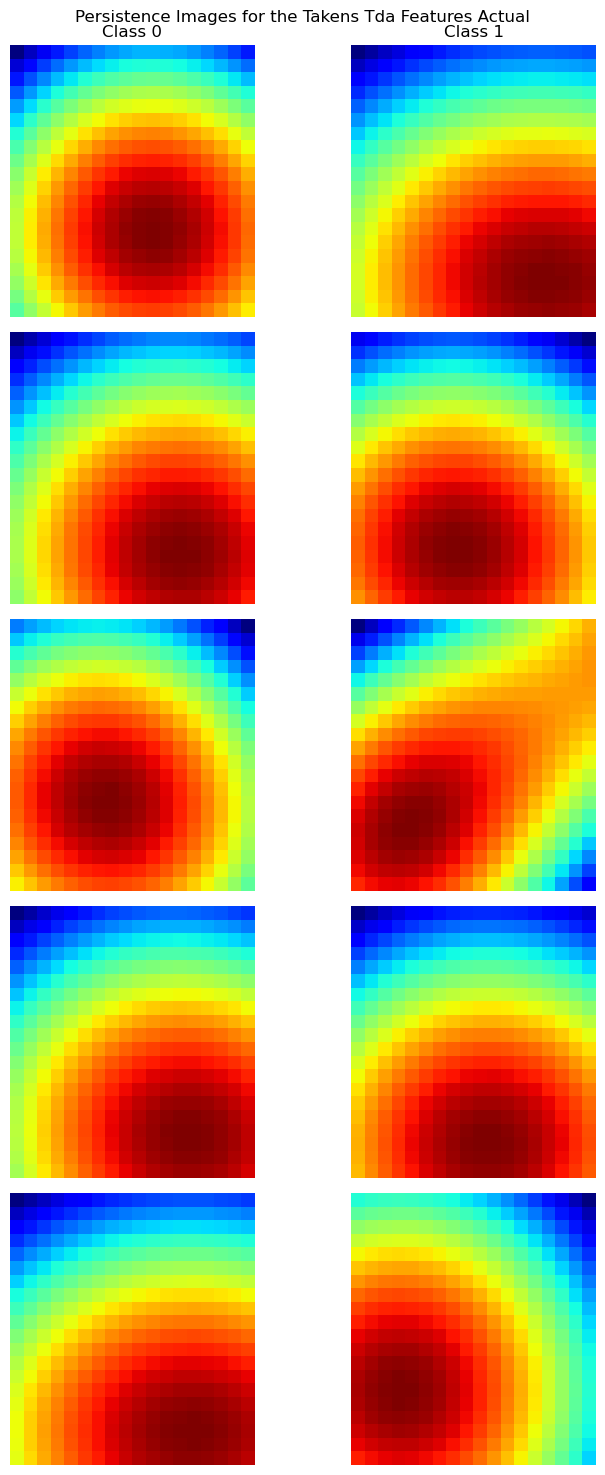

In [14]:
# CELL 15

#labels, persistence_images_normalized = get_tda_features_and_labels(df_train)
#plot_persistence_images(labels, persistence_images_normalized, "normalized_data", samples_per_class=5)

# Ensure necessary variables from previous cells are available:
# - df_train (DataFrame of training data, e.g., from df_train_full.copy())
# - feature_methods (dictionary from Cell D, where feature_methods["TDA"] is the TDA extractor function)
# - CLASS_LABELS (binary class map, e.g., {0: 'Normal', 1: 'Seizure'})
# - auto_pi_shape (tuple, e.g., (H, W) for PI dimensions, from Cell C)

print("\n--- Generating and Plotting Actual Persistence Images for TDA (Takens') Features ---")

if 'df_train' in locals() and 'feature_methods' in locals() and 'auto_pi_shape' in locals() and auto_pi_shape is not None:
    
    # 1. Select a Manageable Subset for Visualization (Optional but Recommended)
    #    Generating PIs for the *entire* df_train just for plotting might be slow
    #    if df_train is very large. We only need enough samples to show 
    #    'samples_per_class' for the plot.
    #    Let's aim for slightly more than needed to ensure enough samples per class.
    num_samples_to_plot_total = 50 # Or a number you deem reasonable for visualization
    if len(df_train) > num_samples_to_plot_total:
        # Stratified sampling to try and get representation from both classes
        # This requires scikit-learn's train_test_split for stratified sampling of a subset
        from sklearn.model_selection import train_test_split
        df_plot_subset, _ = train_test_split(
            df_train, 
            test_size=(1 - num_samples_to_plot_total / len(df_train)), # Calculate fraction to discard
            stratify=df_train['y'], # Stratify by your target column
            random_state=42 # For reproducibility of the subset
        )
        print(f"Using a stratified subset of {len(df_plot_subset)} samples from df_train for PI visualization.")
    else:
        df_plot_subset = df_train # Use all if df_train is already small
        print(f"Using all {len(df_plot_subset)} samples from df_train for PI visualization.")

    # 2. Get the TDA Feature Extraction Function
    tda_extractor_func = feature_methods.get("TDA")

    if tda_extractor_func:
        print(f"Attempting to generate Persistence Images for plotting using the configured TDA extractor...")
        try:
            # Call the TDA extractor on the chosen subset (df_plot_subset)
            # This will use FeatureExtractor.get_tda, which uses get_tda_features_from_precomputed_diagrams
            # with the PI parameters set during FeatureExtractor initialization (from auto_pi_params).
            labels_for_plot_pi, persistence_images_flat_for_plot = tda_extractor_func(df_plot_subset)
            
            if persistence_images_flat_for_plot is not None and persistence_images_flat_for_plot.ndim == 2 and persistence_images_flat_for_plot.shape[0] > 0:
                print(f"Successfully generated {persistence_images_flat_for_plot.shape[0]} flat PIs with {persistence_images_flat_for_plot.shape[1]} features each.")

                # 3. Reshape PIs for Plotting
                #    auto_pi_shape was determined in Cell C, e.g., (height, width) like (10, 10) or (20,20)
                pi_height = auto_pi_shape[0]
                pi_width = auto_pi_shape[1]
                
                if persistence_images_flat_for_plot.shape[1] != (pi_height * pi_width):
                    print(f"ERROR: Flattened PI feature count ({persistence_images_flat_for_plot.shape[1]}) "
                          f"does not match expected from auto_pi_shape ({pi_height}x{pi_width}={pi_height * pi_width}). Cannot reshape correctly.")
                else:
                    # Reshape to (num_samples, height, width) for plot_persistence_images
                    persistence_images_reshaped_for_plot = persistence_images_flat_for_plot.reshape(
                        persistence_images_flat_for_plot.shape[0], 
                        pi_height, 
                        pi_width
                    )
                    print(f"Reshaped PIs to: {persistence_images_reshaped_for_plot.shape}")

                    # 4. Plot the Actual Persistence Images
                    #    Ensure visualization.plot_persistence_images is correctly imported
                    from visualization import plot_persistence_images 
                    
                    plot_persistence_images(
                        labels=labels_for_plot_pi, # Numeric labels (0 or 1)
                        persistence_images=persistence_images_reshaped_for_plot, 
                        name="Takens_TDA_Features_Actual", # Descriptive name
                        samples_per_class=5, # How many to show per class in the plot
                        save=True # Optionally save the image
                        # class_labels_map can be passed if plot_persistence_images is modified to use it for titles,
                        # otherwise it might just use "Class 0", "Class 1".
                        # If your plot_persistence_images uses the label directly in the title (e.g. "Class {label}"),
                        # numeric labels are fine.
                    )
            else:
                print("TDA feature extraction did not return valid persistence images for plotting.")
                if persistence_images_flat_for_plot is not None:
                    print(f"  PIs shape: {persistence_images_flat_for_plot.shape}, PIs ndim: {persistence_images_flat_for_plot.ndim}")


        except Exception as e:
            print(f"ERROR during actual PI generation or plotting: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("ERROR: TDA extractor function not found in `feature_methods`.")
else:
    print("Prerequisite variables (df_train, feature_methods, or auto_pi_shape) not available. Skipping actual PI plotting.")

### Function to plot the persistence diagrams

Plotting PDs for 6 selected series.
Saved Takens PD plot to images/Noiseless_Takens_PDs.png


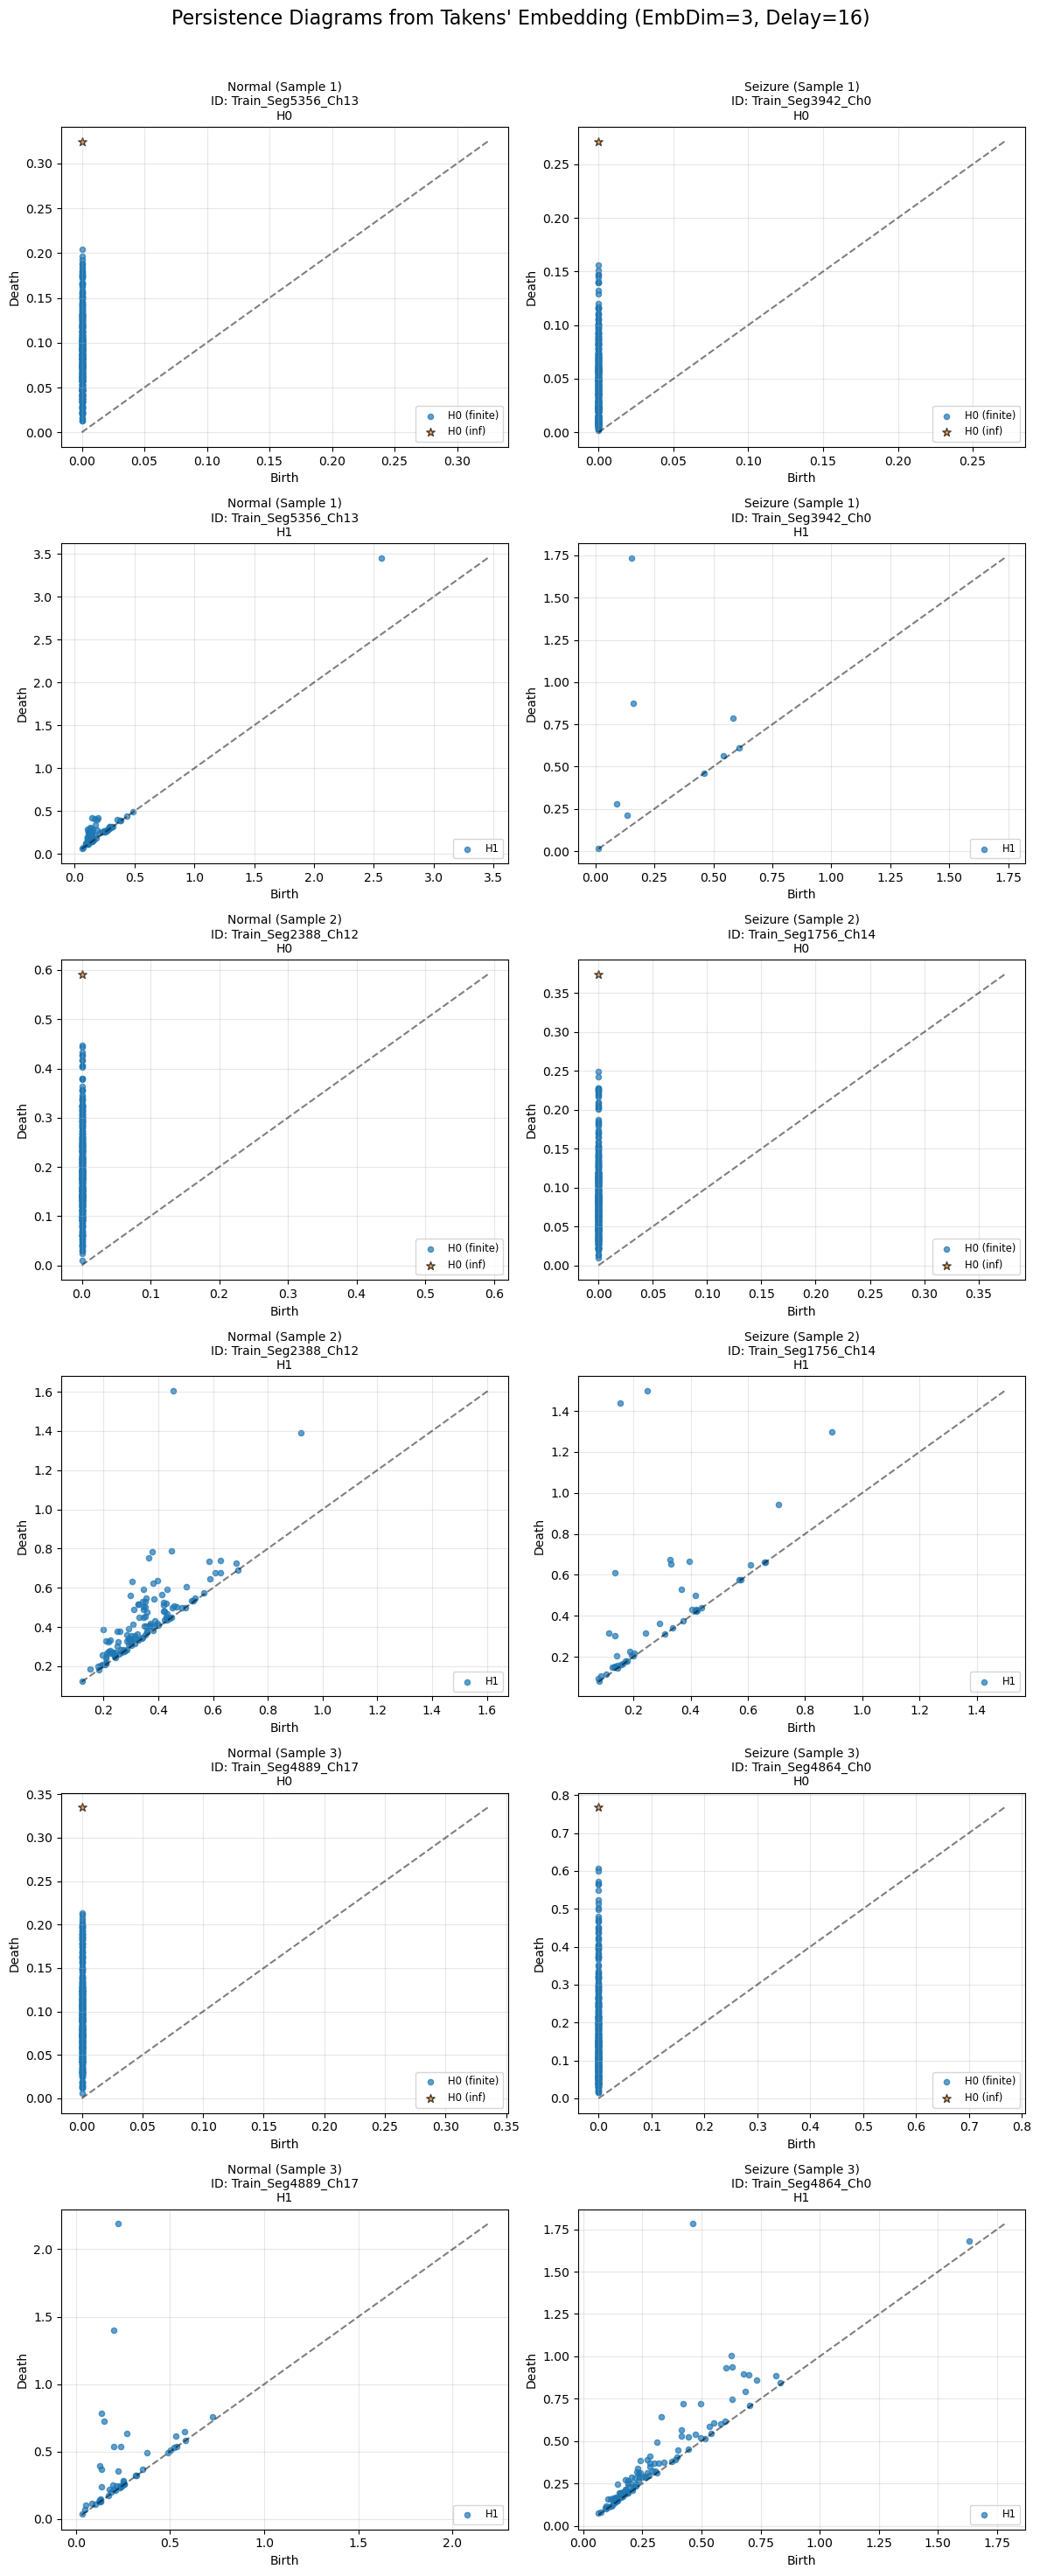

In [16]:
# CELL 16

# Assuming the following are defined in your notebook:
# - df_train_full: Your loaded training DataFrame (e.g., from train_data_processed_preexisting_format.csv)
# - predictors: List of your 'X1'...'X500' column names
# - target: Your target column name (e.g., 'y')
# - class_labels_binary: Your map, e.g., {0: 'Normal', 1: 'Seizure'}
# - global_d: Your computed Takens embedding dimension
# - global_tau: Your computed Takens time delay

# Import the modified function (if not already done)
from visualization import plot_takens_persistence_diagrams

# --- Select a subset of data for plotting PDs ---
# This is important because computing PDs for many series can be slow.
n_plot_samples_per_class = 3 # Let's plot 2 samples from each class

# Ensure your target column contains numeric labels (0 and 1)
df_normal_samples_for_plot = df_train_full[df_train_full[target] == 0].sample(n_plot_samples_per_class, random_state=42, replace=False)
df_seizure_samples_for_plot = df_train_full[df_train_full[target] == 1].sample(n_plot_samples_per_class, random_state=42, replace=False)

# Concatenate the samples from both classes
df_plot_subset_pd = pd.concat([df_normal_samples_for_plot, df_seizure_samples_for_plot])
print(f"Plotting PDs for {len(df_plot_subset_pd)} selected series.")

# --- Call the modified plotting function ---
plot_takens_persistence_diagrams(
    df_subset=df_plot_subset_pd,
    predictor_cols=predictors,
    label_col=target,
    id_col='Unnamed',  # Specify the name of your segment ID column
    class_labels_map=class_labels_binary,
    embedding_dim=global_d, 
    time_delay=global_tau,    
    max_homology_dim=1,     # Compute H0 and H1
    samples_per_class=n_plot_samples_per_class, # This is how many from each class in df_plot_subset will be attempted
    plot_dims_to_show=(0, 1), # Show both H0 and H1 diagrams
    save=True, # Optionally save the figure
    figure_name_suffix="Noiseless_Takens_PDs" # Descriptive suffix for the saved file
)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF DATA WITHOUT NOISE

The next code block is a **setup or configuration step for your entire feature engineering pipeline, especially for the TDA part.**

*   It tells your `FeatureExtractor` *where* to find the already computed diagrams.
*   It tells your `FeatureExtractor` *how* to create Persistence Images from those diagrams (by specifying `pi_params_for_takens`).

If you try to run a Cell that has `run_model_on_features(...)` (or its equivalent) *without* first running this setup block:
*   The `feature_methods` dictionary used by `run_model_on_features` would be created with default parameters (if `get_extractors_methods` in `run_experiments.py` still calls it with no arguments).
*   The `FeatureExtractor` instance wouldn't know about your pre-computed diagrams or your specific PI parameters.
*   Consequently, the TDA feature generation would either fail or not use your pre-computed diagrams and carefully chosen PI settings.



In [17]:
# ==============================================================================
# CELL 16: Configure and Create the Feature Engineering Pipeline
# ==============================================================================
#
# PURPOSE:
# This cell takes all the configuration parameters we've determined in previous
# steps (TDA file paths, automated PI parameters) and uses them to initialize
# our main `FeatureExtractor` class.
#
# The output of this cell is a single, powerful dictionary: `feature_methods`.
# This dictionary maps feature names (like "Baseline", "TDA") to their
# corresponding, fully-configured extraction functions. This dictionary will be
# the sole input required by our model training and evaluation pipeline,
# ensuring a clean separation of concerns.
#
# ==============================================================================

from feature_engineering import get_extractors_methods # Ensure this is the modified version
import os

# --- 1. Define Paths to Pre-computed TDA Data (Parquet Files) ---
# This is the critical fix for the NameError. We explicitly define the paths
# to the Parquet files that store our computed diagrams and labels.

PARQUET_OUTPUT_DIR = "tda_outputs_parquet" 
SAVED_DIAGRAMS_PATH_PARQUET = os.path.join(PARQUET_OUTPUT_DIR, "diagrams_takens.parquet")
SAVED_LABELS_PATH_PARQUET = os.path.join(PARQUET_OUTPUT_DIR, "labels_takens.parquet")

print("\n--- Configuring Feature Extractor Pipeline ---")
print(f"TDA features will be generated from diagrams located at: {SAVED_DIAGRAMS_PATH_PARQUET}")


# --- 2. Verify that required parameters from previous cells exist ---
# This is a defensive check to ensure the notebook has been run in order.
if 'auto_pi_params' not in locals() or auto_pi_params is None or \
   'HOMOLOGY_DIM_TO_ANALYZE' not in locals() or HOMOLOGY_DIM_TO_ANALYZE is None:
    
    raise NameError("Essential TDA parameters ('auto_pi_params', 'HOMOLOGY_DIM_TO_ANALYZE') "
                    "are not defined. Please run the PI Parameter Automation cell first.")
else:
    print("Automated PI parameters and homology dimension confirmed to be available.")


# --- 3. Prepare the Persistence Imager Configuration ---
# The auto_pi_params dictionary already contains the data-driven 'birth_range',
# 'pers_range', and 'pixel_size'. We will pass this directly to the FeatureExtractor.
# We no longer need to pop 'weight' or 'n_jobs' as they were not added in the first place.
pi_config_for_feature_extractor = auto_pi_params
print(f"PersistenceImager will be configured with: {pi_config_for_feature_extractor}")


# --- 4. Instantiate the Feature Extractor via the Helper Function ---
# The get_extractors_methods function now acts as a factory for our main
# FeatureExtractor object, passing all necessary configurations.
# Note: The `pi_shape_tuple` argument is no longer needed by our new, robust
#       `get_tda_features_from_parquet` function, but we can leave it in the
#       call to `get_extractors_methods` if the function signature in
#       feature_engineering.py still accepts it with **kwargs. It will be ignored.

feature_methods = get_extractors_methods(
    scale=True,  # Set to True to apply column-wise StandardScaler to Baseline features.
    
    # Provide the correct Parquet paths for TDA feature generation
    diagrams_path=SAVED_DIAGRAMS_PATH_PARQUET,
    labels_path=SAVED_LABELS_PATH_PARQUET,
    
    # Provide the auto-determined parameters for the PersistenceImager
    pi_params=pi_config_for_feature_extractor,
    pi_hom_dim=HOMOLOGY_DIM_TO_ANALYZE
)

print("\n`feature_methods` dictionary created successfully.")
print("The pipeline is now configured and ready for feature generation and model training.")


--- Configuring Feature Extractor Pipeline ---
TDA features will be generated from diagrams located at: tda_outputs_parquet/diagrams_takens.parquet
Automated PI parameters and homology dimension confirmed to be available.
PersistenceImager will be configured with: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized. TDA configured to use Parquet path: tda_outputs_parquet/diagrams_takens.parquet
PersistenceImager params to be used: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}

`feature_methods` dictionary created successfully.
The pipeline is now configured and ready for feature generation and model training.


## FEATURE GENERATION THEN SAVE THEM

The next code block **GENERATES THE FEATURES (baseline, wavelet, fft, tda) AND SAVES IT TO BE USED IN THE CLASSIFIER TRAINING**

It uses the appropriate function from feature_methods_dict to generate (y_train, X_train) and (y_test, X_test) and then saves these NumPy arrays to disk using a fast and efficient method like joblib or np.save.

In [18]:
# ==============================================================================
# CELL 17: FEATURE SET GENERATION & CACHING (Parquet Version - 4 Files per Feature)
# ==============================================================================
#
# PURPOSE:
# This section computes all required feature sets (Baseline, Wavelet, TDA, FFT)
# for both the training and test data ONCE. The resulting feature matrices are
# saved (cached) to disk using the efficient Parquet file format.
#
# MODIFICATION: This version saves X and y data into SEPARATE Parquet files
# to maintain compatibility with downstream code that expects four files per
# feature set (X_train, y_train, X_test, y_test), mirroring the old joblib structure.
#
# ==============================================================================

import pandas as pd
import numpy as np
import os
import time
import gc # Import Garbage Collector

# --- 1. Configuration ---
FEATURE_CACHE_DIR_PARQUET = "feature_cache_parquet"
os.makedirs(FEATURE_CACHE_DIR_PARQUET, exist_ok=True)
print(f"Feature sets will be saved to and loaded from: '{FEATURE_CACHE_DIR_PARQUET}/'")

# Check if required variables exist before starting
if 'feature_methods' not in locals() or \
   'df_train_full' not in locals() or \
   'df_test_full' not in locals():
    raise NameError("Required variables (feature_methods, df_train_full, df_test_full) not defined. Please run previous cells.")

# List of feature sets to generate and cache
feature_sets_to_process = ["Baseline", "Wavelet", "TDA", "FFT"]


# --- 2. Generation and Caching Loop ---
for feature_name in feature_sets_to_process:
    print(f"\n{'='*20} PROCESSING: {feature_name} Features {'='*20}")
    
    feature_extractor_function = feature_methods.get(feature_name)
    
    if not feature_extractor_function:
        print(f"WARNING: Feature extractor function for '{feature_name}' not found. Skipping.")
        continue

    # --- Process and Cache TRAINING Data ---
    train_start_time = time.time()
    print(f"Generating '{feature_name}' features for the TRAINING set ({len(df_train_full)} samples)...")
    
    y_train_output, X_train_output = feature_extractor_function(df_train_full)
    
    train_end_time = time.time()
    print(f"  -> Done in {train_end_time - train_start_time:.2f} seconds.")
    print(f"     Generated X_train shape: {X_train_output.shape}, y_train shape: {y_train_output.shape}")

    # --- MODIFICATION: Save X and y to SEPARATE Parquet files ---
    # Create DataFrames for X and y
    df_X_train = pd.DataFrame(X_train_output, columns=[f'feat_{i}' for i in range(X_train_output.shape[1])])
    df_y_train = pd.DataFrame(y_train_output, columns=['label'])

    # Define file paths for caching (4 files per feature set)
    X_train_path = os.path.join(FEATURE_CACHE_DIR_PARQUET, f'X_train_{feature_name.lower()}.parquet')
    y_train_path = os.path.join(FEATURE_CACHE_DIR_PARQUET, f'y_train_{feature_name.lower()}.parquet')
    
    # Save to Parquet
    df_X_train.to_parquet(X_train_path, engine='pyarrow', index=False)
    df_y_train.to_parquet(y_train_path, engine='pyarrow', index=False)
    print(f"     Successfully cached training features to:")
    print(f"       - {X_train_path}")
    print(f"       - {y_train_path}")

    # --- Process and Cache TEST Data ---
    test_start_time = time.time()
    print(f"Generating '{feature_name}' features for the TEST set ({len(df_test_full)} samples)...")
    
    y_test_output, X_test_output = feature_extractor_function(df_test_full)
    
    test_end_time = time.time()
    print(f"  -> Done in {test_end_time - test_start_time:.2f} seconds.")
    print(f"     Generated X_test shape: {X_test_output.shape}, y_test shape: {y_test_output.shape}")
    
    # --- MODIFICATION: Save X and y to SEPARATE Parquet files ---
    df_X_test = pd.DataFrame(X_test_output, columns=[f'feat_{i}' for i in range(X_test_output.shape[1])])
    df_y_test = pd.DataFrame(y_test_output, columns=['label'])

    # Define file paths for caching
    X_test_path = os.path.join(FEATURE_CACHE_DIR_PARQUET, f'X_test_{feature_name.lower()}.parquet')
    y_test_path = os.path.join(FEATURE_CACHE_DIR_PARQUET, f'y_test_{feature_name.lower()}.parquet')
    
    # Save to Parquet
    df_X_test.to_parquet(X_test_path, engine='pyarrow', index=False)
    df_y_test.to_parquet(y_test_path, engine='pyarrow', index=False)
    print(f"     Successfully cached test features to:")
    print(f"       - {X_test_path}")
    print(f"       - {y_test_path}")

    # --- Explicitly release memory before next loop iteration ---
    print(f"     Clearing memory for '{feature_name}' feature set...")
    del y_train_output, X_train_output, y_test_output, X_test_output
    del df_X_train, df_y_train, df_X_test, df_y_test
    gc.collect() # Trigger garbage collection
    print("     Memory cleared for the feature in this iteration.")

print("\n\n--- Feature Caching Complete ---")
print("All feature sets for both training and test data have been generated and saved as separate X/y Parquet files.")

Feature sets will be saved to and loaded from: 'feature_cache_parquet/'

==================== PROCESSING: Baseline Features ====================
Generating 'Baseline' features for the TRAINING set (133209 samples)...
  -> Done in 0.82 seconds.
     Generated X_train shape: (133209, 500), y_train shape: (133209,)
     Successfully cached training features to:
       - feature_cache_parquet/X_train_baseline.parquet
       - feature_cache_parquet/y_train_baseline.parquet
Generating 'Baseline' features for the TEST set (14801 samples)...
  -> Done in 0.08 seconds.
     Generated X_test shape: (14801, 500), y_test shape: (14801,)
     Successfully cached test features to:
       - feature_cache_parquet/X_test_baseline.parquet
       - feature_cache_parquet/y_test_baseline.parquet
     Clearing memory for 'Baseline' feature set...
     Memory cleared for the feature in this iteration.

==================== PROCESSING: Wavelet Features ====================
Generating 'Wavelet' features for th

### Low Complexity Classifier Training (Seconds to Minutes)

**1. `Ridge Classifier`**
*   **Time Complexity:** **Very Low**. The complexity with the default `'auto'` solver is often dominated by **O(D² * N)** for `svd` or `cholesky` solvers, which are direct (non-iterative) methods.
*   **Reasoning:** This is the fastest of the bunch. For `solver='auto'`, scikit-learn will likely choose a direct matrix decomposition method like SVD or Cholesky decomposition because your number of samples (N) is much larger than your number of features (D). These solvers are extremely fast and don't require iterative convergence. Your updated hyperparameter grid wisely sticks to `solver='auto'` and only tunes `alpha`, making this a very quick grid search.
   
**2. `Logistic Regression` (as implemented via `SGDClassifier(loss='log_loss')`)**
*   **Time Complexity:** **Low**. Identical complexity to the standard `SGDClassifier`.
*   **Reasoning:** Your new `run_logistic_regression` function correctly uses `SGDClassifier` with `loss='log_loss'`. This is simply a specific configuration of the highly efficient SGD algorithm. It will be very fast to train and tune.
  
**3. `SGD Classifier` (with Hinge Loss / standard SVM)**
*   **Time Complexity:** **Low**. The complexity of Stochastic Gradient Descent is **O(N * D * i)**, where *i* is the number of epochs.
*   **Reasoning:** This is what you ran as `run_sgd_classifier`. `SGDClassifier` is extremely fast and scalable because it updates the model's weights using only a single sample (or a small mini-batch) at a time. It doesn't need to look at the entire dataset for each update. With `early_stopping`, it can converge very quickly, often in just a few passes over the data. This is one of the fastest algorithms for large-scale linear classification.

---

**Summary Table:**

| Rank | Classifier | Est. Relative Runtime | Key Factor |
| :--- | :--- | :--- | :--- |
| 1 | **Ridge Classifier** | Seconds | Uses fast, direct matrix-based solvers. |
| 2 | **Logistic Regression (SGD)**| Seconds to Minutes | A specific configuration of `SGDClassifier`. |
| 3 | **SGD Classifier** | Seconds to Minutes | Stochastic updates, very scalable. |




############################################################
# STARTING EXPERIMENTS FOR: Ridge Classifier
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: Ridge Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for Ridge Classifier...
    INFO: [RidgeClassifier] Using efficient grid search (tuning alpha only) and having solver set to auto.
    DEBUG: [Ridge Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [Ridge Classifier Baseline] tr

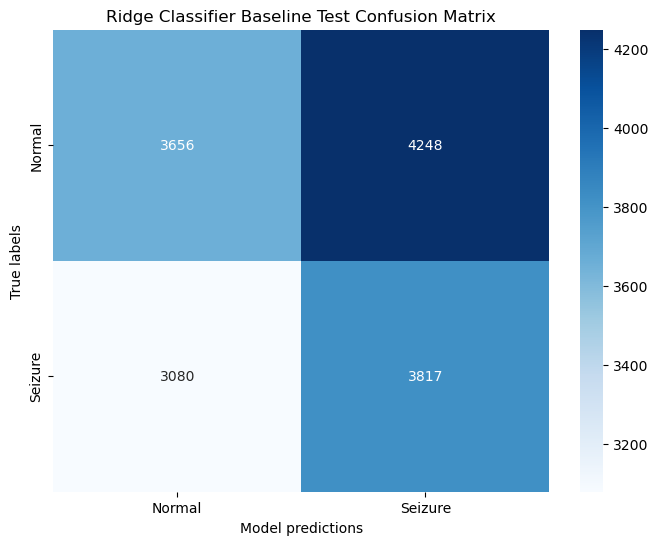

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: Ridge Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for Ridge Classifier...
    INFO: [RidgeClassifier] Using efficient grid search (tuning alpha only) and having solver set to auto.
    DEBUG: [Ridge Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [Ridge Classifier Wavelet] train_and_tune_model: Param grid: {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto'

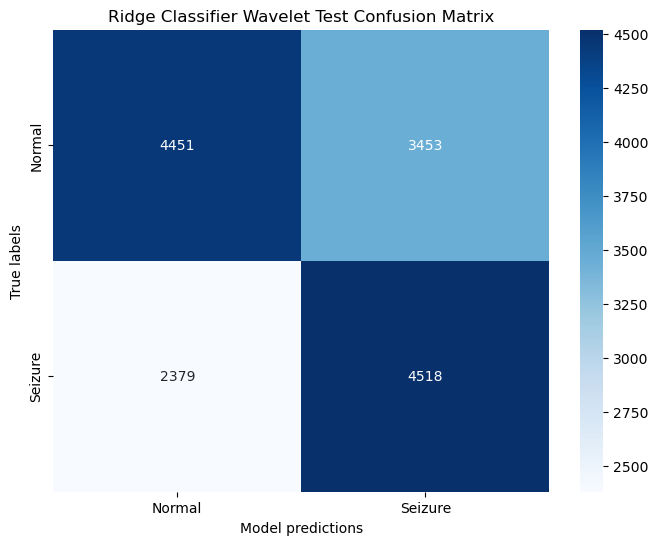

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: Ridge Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for Ridge Classifier...
    INFO: [RidgeClassifier] Using efficient grid search (tuning alpha only) and having solver set to auto.
    DEBUG: [Ridge Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [Ridge Classifier TDA] train_and_tune_model: Param grid: {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto']}
    DEBUG: [

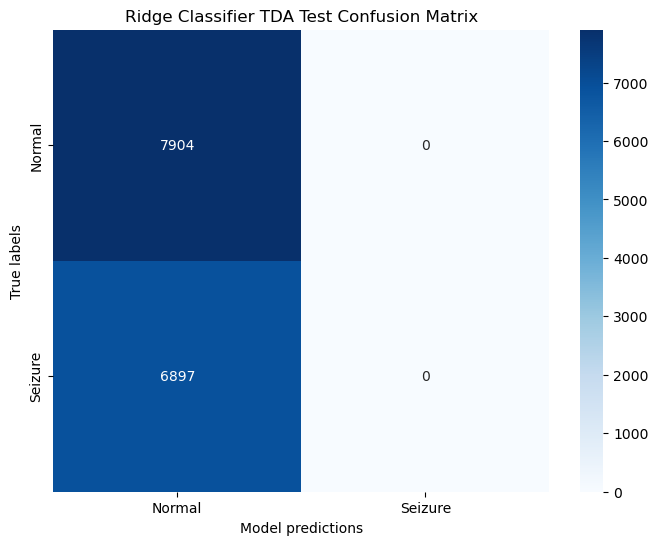

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: Ridge Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for Ridge Classifier...
    INFO: [RidgeClassifier] Using efficient grid search (tuning alpha only) and having solver set to auto.
    DEBUG: [Ridge Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [Ridge Classifier FFT] train_and_tune_model: Param grid: {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto']}
    DEBUG: [Ridg

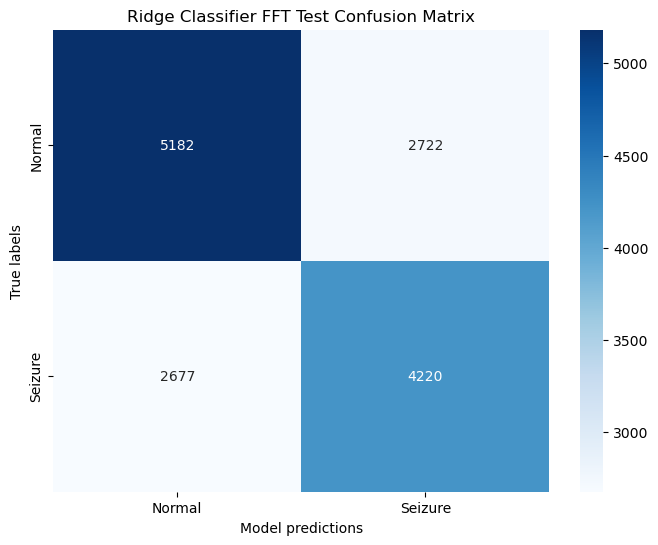

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR Ridge Classifier COMPLETE.
############################################################


In [19]:
# ==============================================================================
# CELL 18: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This section orchestrates the model training by loading ONE feature set at a time
# from the Parquet cache, running the specified model, and then clearing the data
# from memory. This is the most robust and memory-safe architecture for running
# experiments.
#
# ==============================================================================

import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Use the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
# You can comment out lines to test on a subset of features.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules
from run_experiments import run_model_on_single_feature_set, run_ridge_classifier

# --- 2. Main Training Loop for Ridge Classifier ---

# ===============================================
# Running the Ridge Classifier
# ===============================================
model_to_run_name = "Ridge Classifier"
model_to_run_fn = run_ridge_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name}\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # === MODIFICATION: Load from Parquet and convert to NumPy arrays ===
        # pd.read_parquet returns a DataFrame. We use .values to get the underlying NumPy array.
        # For the labels, we use .squeeze() or .iloc[:, 0] to convert the single-column DataFrame
        # back into a 1D array, which is what scikit-learn models expect.
        
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### Logistic Regression with different extractors


############################################################
# STARTING EXPERIMENTS FOR: Logistic Regression
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: Logistic Regression on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for Logistic Regression...
    INFO: [Logistic Regression Baseline] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [Logistic Regression Baseline]

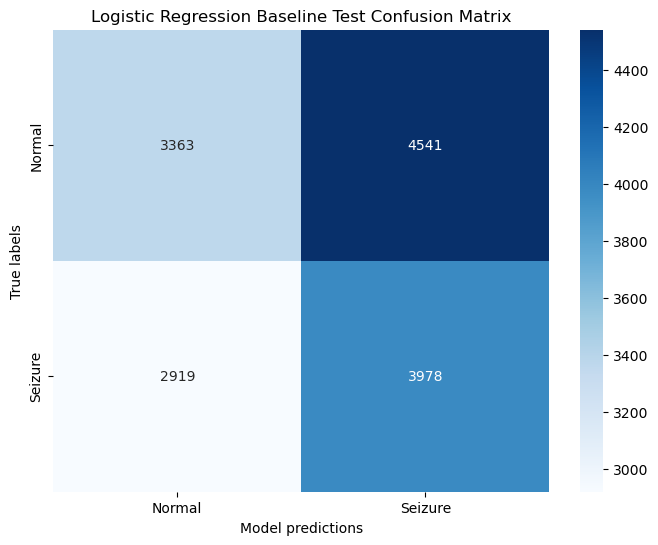

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: Logistic Regression on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for Logistic Regression...
    INFO: [Logistic Regression Wavelet] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [Logistic Regression Wavelet] train_and_tune_model: Param grid: {'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty

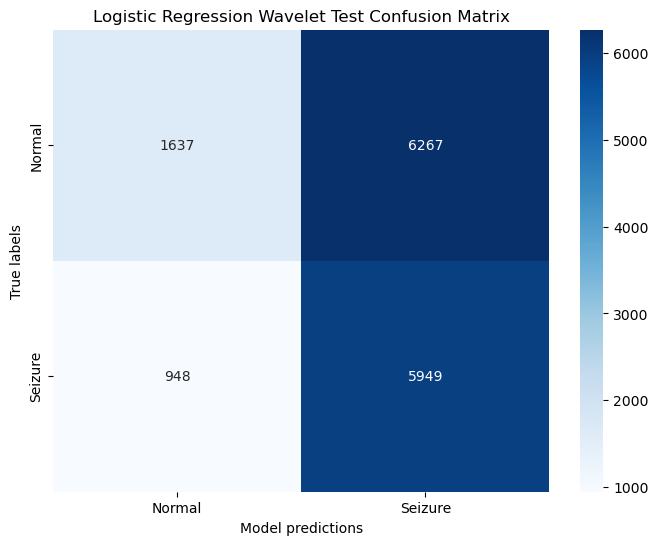

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: Logistic Regression on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for Logistic Regression...
    INFO: [Logistic Regression TDA] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [Logistic Regression TDA] train_and_tune_model: Param grid: {'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l2', 'l1', 'el

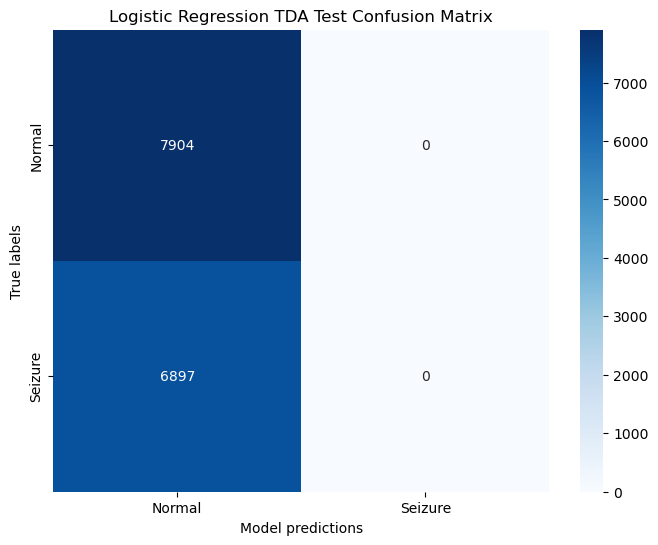

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: Logistic Regression on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for Logistic Regression...
    INFO: [Logistic Regression FFT] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [Logistic Regression FFT] train_and_tune_model: Param grid: {'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l2', 'l1', 'elasti

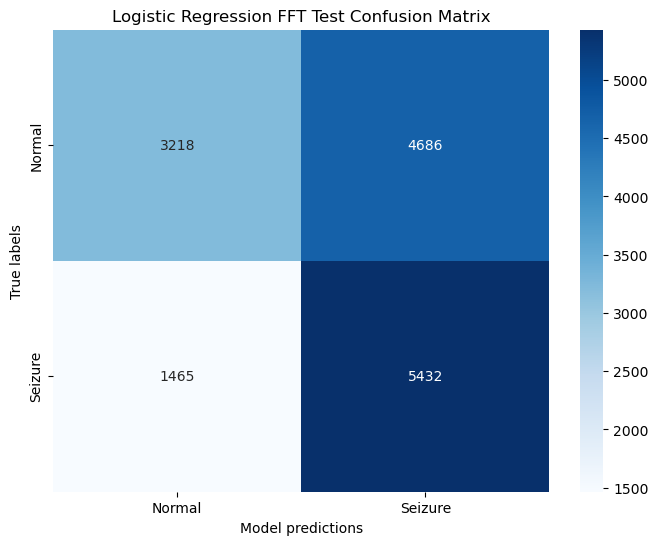

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR Logistic Regression COMPLETE.
############################################################


In [20]:
# ==============================================================================
# CELL 18: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the Logistic Regression classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================

import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---

# ===============================================
# Running the Logistic Regression Classifier
# ===============================================
model_to_run_name = "Logistic Regression"
model_to_run_fn = run_logistic_regression
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name}\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### SGD Classifier



############################################################
# STARTING EXPERIMENTS FOR: SGD Classifier
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: SGD Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for SGD Classifier...
    DEBUG: [SGD Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [SGD Classifier Baseline] train_and_tune_model: Param grid: {'loss': ['hinge', 'log_loss'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.00

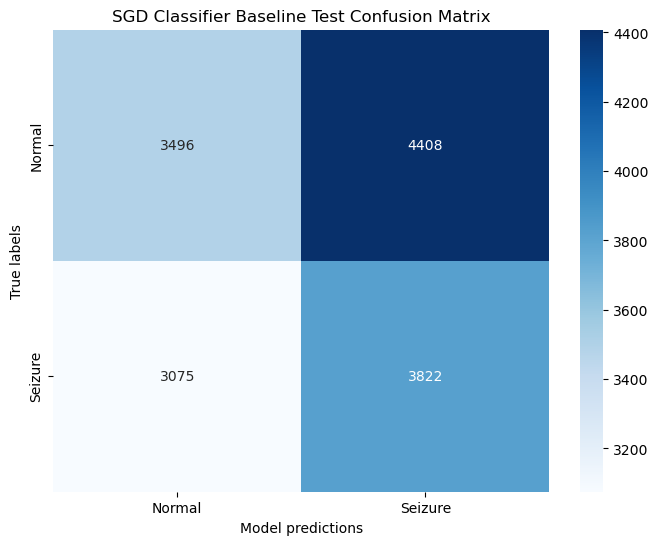

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: SGD Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for SGD Classifier...
    DEBUG: [SGD Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [SGD Classifier Wavelet] train_and_tune_model: Param grid: {'loss': ['hinge', 'log_loss'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000, 2000]}
    DEBUG: [SGD Classifier Wave

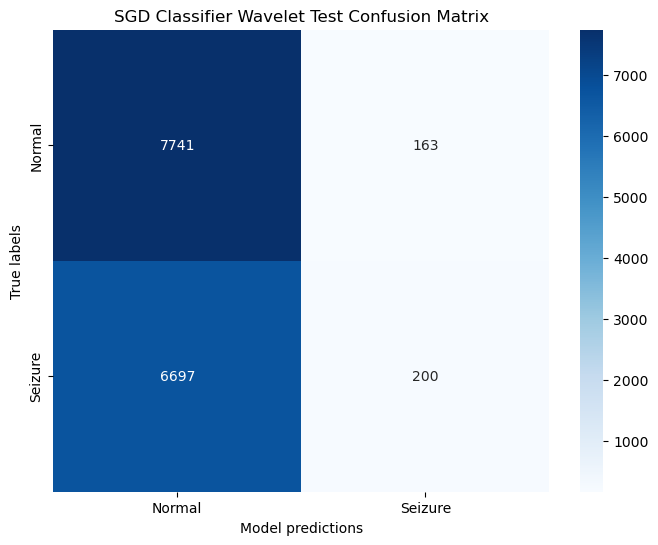

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: SGD Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for SGD Classifier...
    DEBUG: [SGD Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [SGD Classifier TDA] train_and_tune_model: Param grid: {'loss': ['hinge', 'log_loss'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000, 2000]}
    DEBUG: [SGD Classifier TDA] train_and_tune

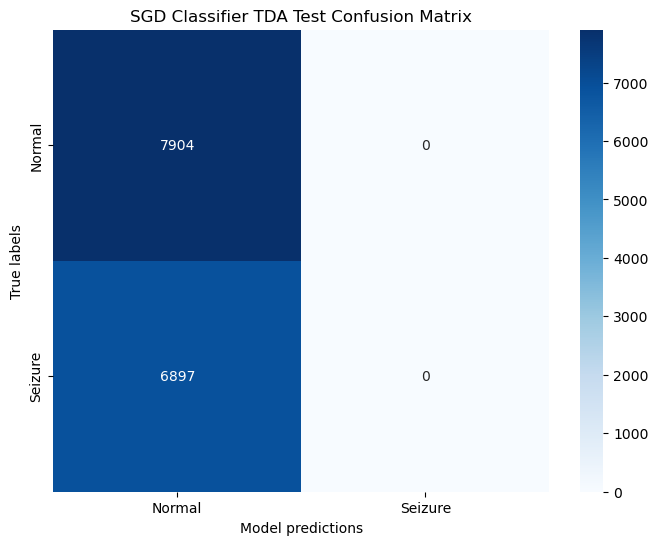

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: SGD Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for SGD Classifier...
    DEBUG: [SGD Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [SGD Classifier FFT] train_and_tune_model: Param grid: {'loss': ['hinge', 'log_loss'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000, 2000]}
    DEBUG: [SGD Classifier FFT] train_and_tune_mod

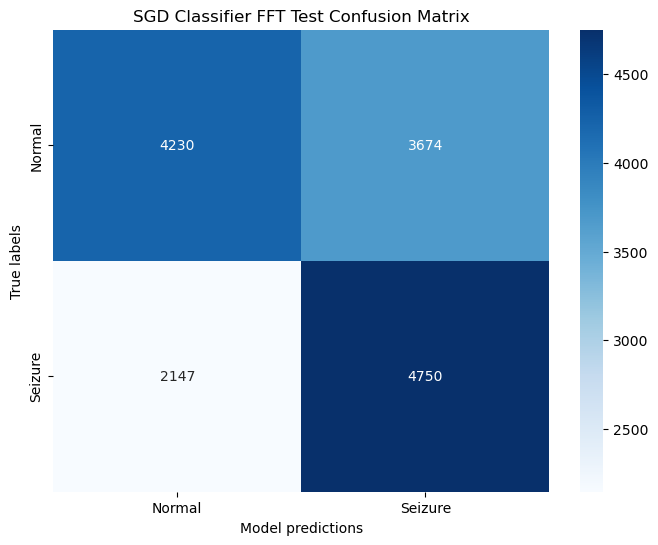

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR SGD Classifier COMPLETE.
############################################################


In [21]:
#run_model_on_features(df_train, "SGD Classifier", run_sgd_classifier)

# ==============================================================================
# CELL 19: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the SGD classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================

import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---

# ===============================================
# Running the SGD Classifier
# ===============================================
model_to_run_name = "SGD Classifier"
model_to_run_fn = run_sgd_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name}\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

### **Classifier Training Time Complexity Ranking**

Here is the ranking of the remaining classifiers from **least computationally expensive (fastest)** to **most computationally expensive (slowest)**, considering their typical behavior on a dataset of size ~100k samples with 500 features within a `GridSearchCV` loop.


**1. `Random Forest Classifier`**
*   **Time Complexity:** **Moderate**.
*   **Reasoning:** Random Forest is an ensemble of decision trees. Crucially, each tree in the forest can be built **independently and in parallel**. If you set `n_jobs=-1` (which is a default behavior within `GridSearchCV` unless overridden), Random Forest can take full advantage of multi-core CPUs. While it's still training hundreds of trees (`n_estimators`), this parallelism makes it significantly faster than sequential gradient boosting methods like XGBoost or CatBoost for a comparable number of trees.

**2. `XGBoost Classifier`**
*   **Time Complexity:** **Moderate to High**. Similar complexity characteristics to CatBoost.
*   **Reasoning:** Like CatBoost, XGBoost builds trees sequentially. It is known for its speed and efficiency, often being faster than other gradient boosting libraries depending on the dataset and hardware. The tuning grid (`n_estimators`, `max_depth`, `learning_rate`) is similar to CatBoost's, and it will also represent a significant but manageable workload. The relative speed of CatBoost vs. XGBoost can vary.

**3. `CatBoost Classifier`**
*   **Time Complexity:** **Moderate to High**. Gradient Boosting models involve iteratively building a series of decision trees.
*   **Reasoning:** CatBoost is a highly optimized gradient boosting library. It's generally very fast, but its performance depends heavily on the hyperparameters being tuned: `iterations` (number of trees), `depth` (complexity of each tree), and `learning_rate`. Your grid search explores these key parameters, so it will be a substantial computation. It is typically slower than Random Forest because the trees are built sequentially, not in parallel.

**4. `KNeighborsClassifier` (KNN)**
*   **Time Complexity:** **High, but Deceptive**.
    *   **Training (Fit) Time:** **Extremely Fast, O(1)**. KNN has virtually no training phase; it simply stores the entire training dataset in memory.
    *   **Prediction (GridSearchCV's evaluation) Time:** **Very Slow, O(N * K * D)** for each prediction point.
*   **Reasoning:** The slowness comes from the evaluation phase within `GridSearchCV`. For each of the `cv=3` folds, the model "trains" instantly on the training part. But then, to evaluate on the validation part, it must compute the distance from *every single validation point* to *every single training point* to find the K-nearest neighbors. This makes the cross-validation step very computationally expensive, especially as N grows.

**5. `MLP Classifier` (Multi-Layer Perceptron)**
*   **Time Complexity:** **High**. The complexity is roughly **O(N * D * H * O * i)**, where N is samples, D is input features, H is the number of neurons in the hidden layers, O is the number of output neurons, and *i* is the number of training iterations (epochs).
*   **Reasoning:** While its complexity scales linearly with N (much better than SVC), the constant factors are very large. Training involves forward and backward propagation of gradients through the network for many epochs. Your `param_grid` explores different architectures (`hidden_layer_sizes`), and the `max_iter` is set to 1000. This combination, repeated for each fold and hyperparameter set in `GridSearchCV`, results in a very high computational load. It will be significantly slower than tree-based methods.

**6.  `SVC Classifier` (with RBF kernel)**
*   **Time Complexity:** **Extremely High**. The complexity is approximately **O(N² * D)** to **O(N³ * D)** for the `rbf` kernel, where N is the number of samples and D is the number of features.
*   **Reasoning:** The RBF kernel requires computing a pairwise distance matrix between all samples (or a large subset), making it fundamentally dependent on the square of the number of samples. With N > 100,000, the N² term dominates all other factors, leading to extreme runtimes. This will be, by an enormous margin, the slowest model to tune. The `linear` kernel option within `SVC` is faster but is often outperformed by the dedicated `LinearSVC` implementation.

---

**Summary Table for Your Planning:**

| Rank | Classifier | Est. Relative Runtime | Key Factor |
| :--- | :--- | :--- | :--- |
| 1 | **Random Forest** | Minutes | Parallel tree building (bagging). |
| 2 | **XGBoost** | Minutes to Hours | Sequential tree building (gradient boosting). |
| 3 | **CatBoost** | Minutes to Hours | Sequential tree building (gradient boosting). |
| 4 | **KNN Classifier** | Hours | **O(N)** cost *per prediction* during cross-validation. |
| 5 | **MLP Classifier** | Hours | High constant factor, many iterations (epochs). |
| 6 | **SVC (with RBF)** | Days (Potentially) | **O(N²)** algorithmic complexity. Infeasible. |

**Execution Strategy Based on this Ranking:**

1.  **Run Random Forest First:** It will be the fastest and will give a quick, strong baseline for the tree-based methods.
2.  **Run XGBoost and CatBoost:** These will take longer but are likely to be the best-performing models. Run them when the compute time can be afforded.
3.  **Run KNN and MLP:** Be prepared for these to take a significant amount of time. Run them overnight or on a more powerful machine if available. Consider using strategic subsampling for their hyperparameter tuning, similar to the plan for SVC.
4.  **Handle SVC Separately:** **Do not** run `SVC` with the `rbf` kernel in a full `GridSearchCV` on the entire training set. It will not finish in a reasonable timeframe. A subsampling strategy **must** be used to tune its hyperparameters, then train a single final model on the full data.

#### Random Forest


############################################################
# STARTING EXPERIMENTS FOR: Random Forest Classifier
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: Random Forest Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for Random Forest Classifier...
    INFO: [Random Forest Classifier Baseline] Using bounded 'max_depth' in grid search to ensure memory safety.
    DEBUG: [Random Forest Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    

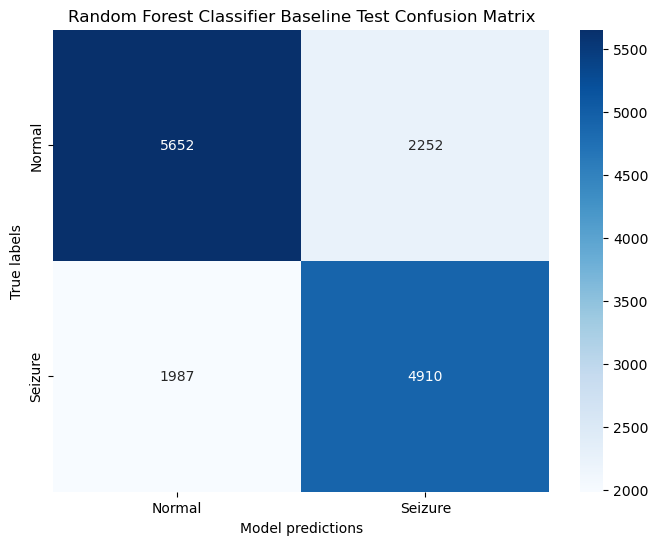

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: Random Forest Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for Random Forest Classifier...
    INFO: [Random Forest Classifier Wavelet] Using bounded 'max_depth' in grid search to ensure memory safety.
    DEBUG: [Random Forest Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [Random Forest Classifier Wavelet] train_and_tune_model: Param grid: {'n_estim

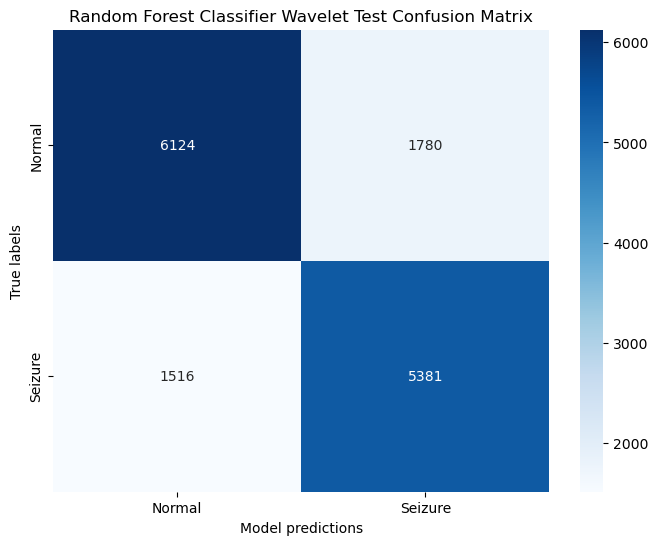

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: Random Forest Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for Random Forest Classifier...
    INFO: [Random Forest Classifier TDA] Using bounded 'max_depth' in grid search to ensure memory safety.
    DEBUG: [Random Forest Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [Random Forest Classifier TDA] train_and_tune_model: Param grid: {'n_estimators': [100, 200],

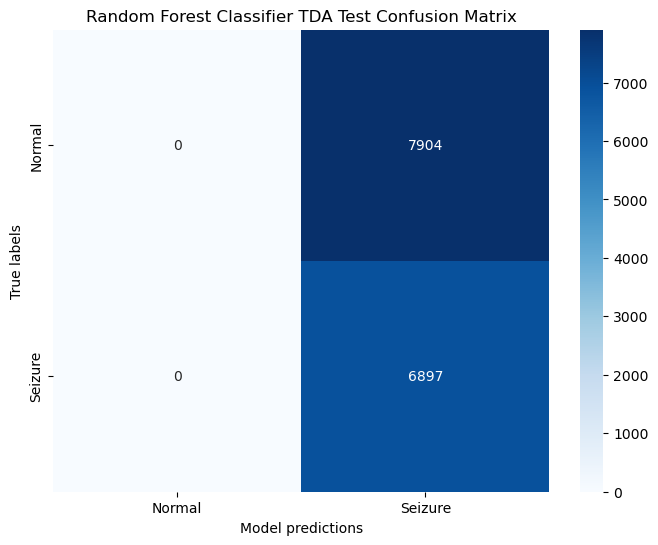

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: Random Forest Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for Random Forest Classifier...
    INFO: [Random Forest Classifier FFT] Using bounded 'max_depth' in grid search to ensure memory safety.
    DEBUG: [Random Forest Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [Random Forest Classifier FFT] train_and_tune_model: Param grid: {'n_estimators': [100, 200], 'ma

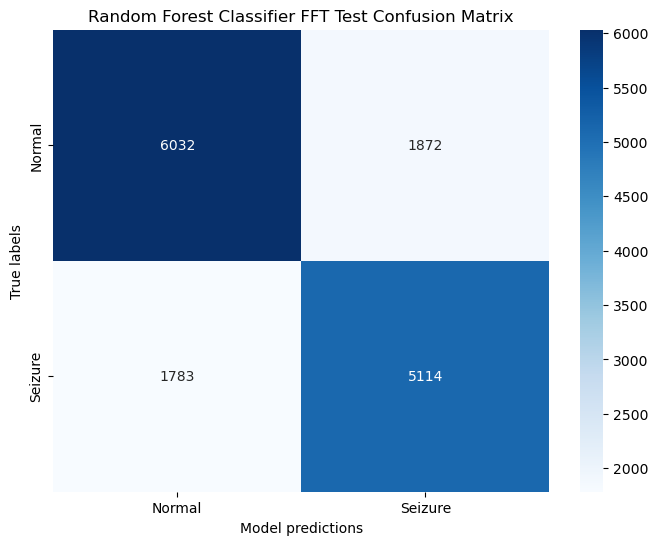

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR Random Forest Classifier COMPLETE.
############################################################


In [22]:
# ==============================================================================
# CELL 20: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the SGD classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================


import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---

# ===============================================
# Running the SGD Classifier
# ===============================================
model_to_run_name = "Random Forest Classifier"
model_to_run_fn = run_random_forest_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name} (Noiseless Data)\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### XGBoost


############################################################
# STARTING EXPERIMENTS FOR: XGBoost (Noiseless Data)
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: XGBoost on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for XGBoost...
    DEBUG: [XGBoost Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [XGBoost Baseline] train_and_tune_model: Param grid: {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [XGBoost Bas

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:31:56] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   9.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:05] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   8.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:14] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   9.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:24] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  17.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:40] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  16.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:57] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  17.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:14] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  16.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:30] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  15.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:46] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  16.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:34:03] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  30.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:34:33] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  29.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:35:02] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  32.8s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:35:35] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:35:44] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:35:54] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  10.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:05] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  19.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:24] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  20.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:45] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  20.8s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:37:05] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  18.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:37:23] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  18.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:37:42] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  19.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:38:01] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  33.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:38:35] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  32.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:08] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  33.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:39:41] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    <--- [XGBoost Baseline] GridSearchCV.fit() COMPLETED.

  Evaluating best XGBoost (with Baseline) on TEST set...

Test Results:
              precision    recall  f1-score   support

      Normal       0.69      0.65      0.67      7904
     Seizure       0.62      0.67      0.65      6897

    accuracy                           0.66     14801
   macro avg       0.66      0.66      0.66     14801
weighted avg       0.66      0.66      0.66     14801



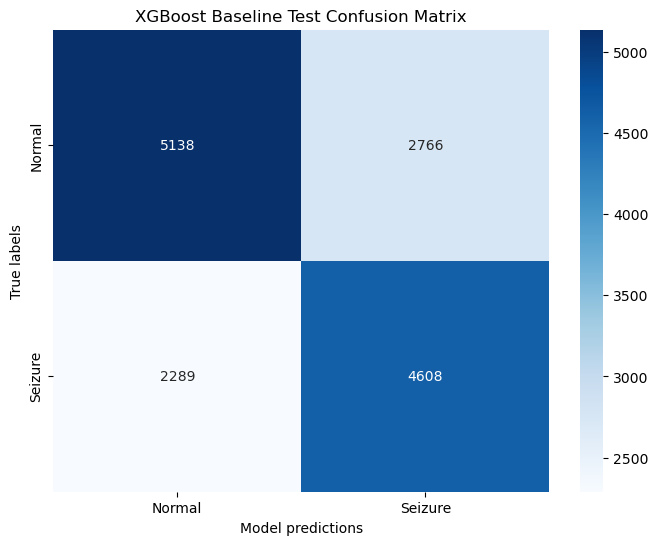

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: XGBoost on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for XGBoost...
    DEBUG: [XGBoost Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [XGBoost Wavelet] train_and_tune_model: Param grid: {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [XGBoost Wavelet] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs=1
    --

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:27] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:27] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:27] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:28] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:28] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:29] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:29] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:30] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:31] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:32] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=   1.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:33] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=   1.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:34] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=   1.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:35] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:36] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:36] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:36] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:37] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:37] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:38] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:39] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:39] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:40] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:41] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:42] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:44] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    <--- [XGBoost Wavelet] GridSearchCV.fit() COMPLETED.

  Evaluating best XGBoost (with Wavelet) on TEST set...

Test Results:
              precision    recall  f1-score   support

      Normal       0.77      0.72      0.74      7904
     Seizure       0.70      0.75      0.72      6897

    accuracy                           0.73     14801
   macro avg       0.73      0.73      0.73     14801
weighted avg       0.73      0.73      0.73     14801



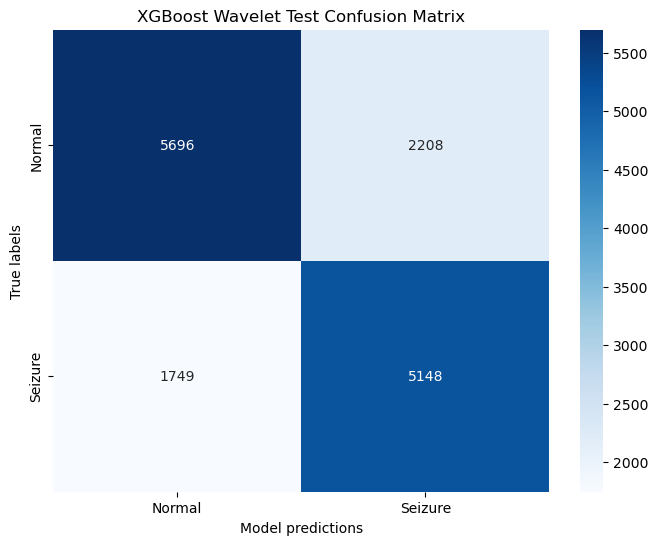

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: XGBoost on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for XGBoost...
    DEBUG: [XGBoost TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [XGBoost TDA] train_and_tune_model: Param grid: {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [XGBoost TDA] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs=1
    ---> [XGBoost TDA] CA

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:40:47] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  12.8s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:41:00] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  13.8s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:41:14] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  13.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:41:28] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  27.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:41:56] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:42:24] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  28.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:42:52] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  17.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:43:09] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  17.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:43:27] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=  17.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:43:44] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  32.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:44:17] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  33.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:44:50] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  33.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:45:24] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  13.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:45:38] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  13.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:45:51] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  13.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:46:05] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  26.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:46:31] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  26.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:46:58] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  26.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:47:24] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  15.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:47:39] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  15.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:47:55] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  15.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:48:10] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  29.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:48:39] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  28.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:49:08] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  28.9s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:49:37] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    <--- [XGBoost TDA] GridSearchCV.fit() COMPLETED.

  Evaluating best XGBoost (with TDA) on TEST set...

Test Results:
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00      7904
     Seizure       0.47      1.00      0.64      6897

    accuracy                           0.47     14801
   macro avg       0.73      0.50      0.32     14801
weighted avg       0.75      0.47      0.30     14801



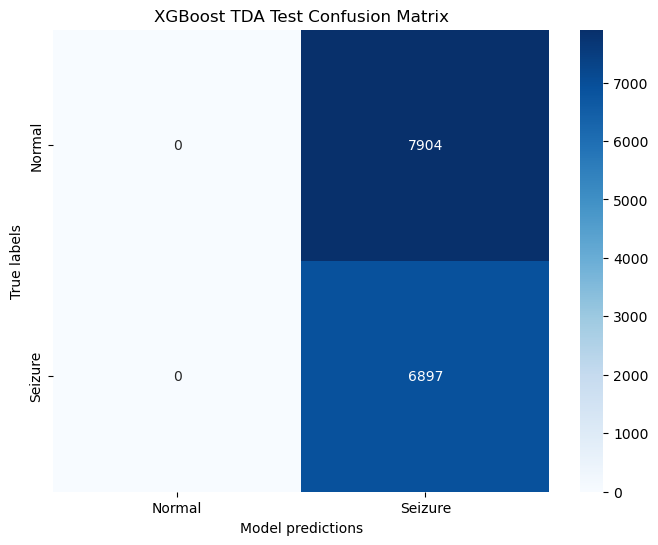

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: XGBoost on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for XGBoost...
    DEBUG: [XGBoost FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [XGBoost FFT] train_and_tune_model: Param grid: {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [XGBoost FFT] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs=1
    ---> [XGBoost FFT] CALLIN

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:18] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   5.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:23] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   5.0s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:28] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   5.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:33] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   9.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:43] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   9.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:50:52] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   9.6s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:51:02] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   9.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:51:11] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   9.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:51:21] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   8.7s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:51:29] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  16.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:51:46] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  16.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:02] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  16.4s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:18] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.9s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:22] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   4.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:26] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   4.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:31] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:38] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:45] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:52] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   7.2s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:52:59] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   7.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:53:07] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   7.3s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:53:14] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  12.9s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:53:27] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  14.1s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:53:41] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=  13.5s


/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:53:55] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    <--- [XGBoost FFT] GridSearchCV.fit() COMPLETED.

  Evaluating best XGBoost (with FFT) on TEST set...

Test Results:
              precision    recall  f1-score   support

      Normal       0.73      0.74      0.73      7904
     Seizure       0.70      0.69      0.69      6897

    accuracy                           0.72     14801
   macro avg       0.71      0.71      0.71     14801
weighted avg       0.72      0.72      0.72     14801



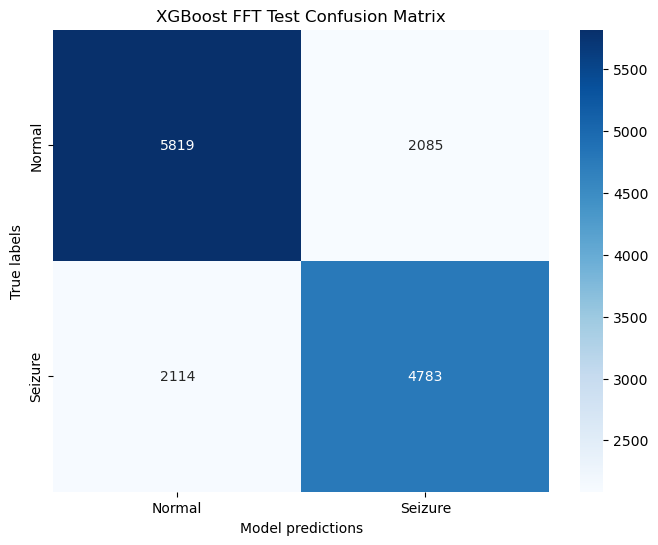

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR XGBoost COMPLETE.
############################################################


In [23]:
# ==============================================================================
# CELL 21: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the SGD classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================


import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---

# ===============================================
# Running the SGD Classifier
# ===============================================
model_to_run_name = "XGBoost"
model_to_run_fn = run_xgboost_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name} (Noiseless Data)\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### CatBoost



############################################################
# STARTING EXPERIMENTS FOR: CatBoost Classifier (Noiseless Data)
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: CatBoost Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for CatBoost Classifier...
    DEBUG: [CatBoost Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [CatBoost Classifier Baseline] train_and_tune_model: Param grid: {'iterations': [100, 200], 'depth': [3, 6],

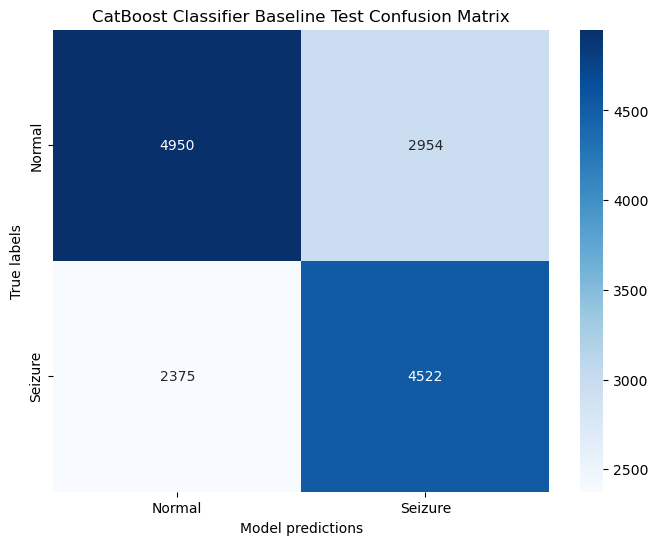

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: CatBoost Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for CatBoost Classifier...
    DEBUG: [CatBoost Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [CatBoost Classifier Wavelet] train_and_tune_model: Param grid: {'iterations': [100, 200], 'depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [CatBoost Classifier Wavelet] train_and_tune_model: Gri

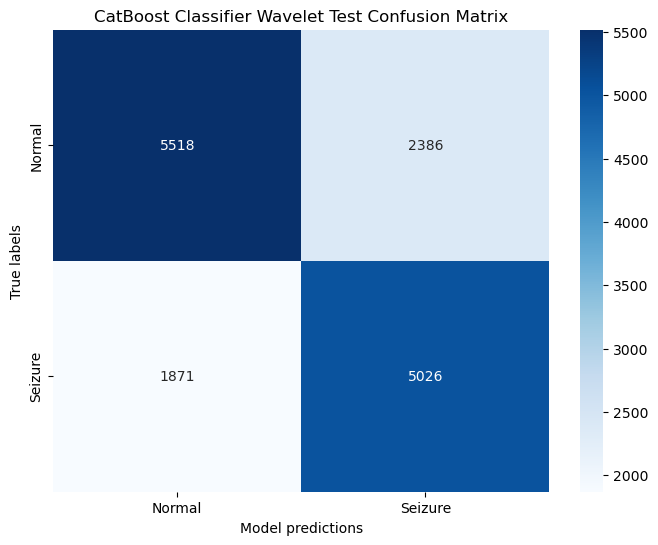

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: CatBoost Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for CatBoost Classifier...
    DEBUG: [CatBoost Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [CatBoost Classifier TDA] train_and_tune_model: Param grid: {'iterations': [100, 200], 'depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [CatBoost Classifier TDA] train_and_tune_model: GridSearchCV cv=3, sco

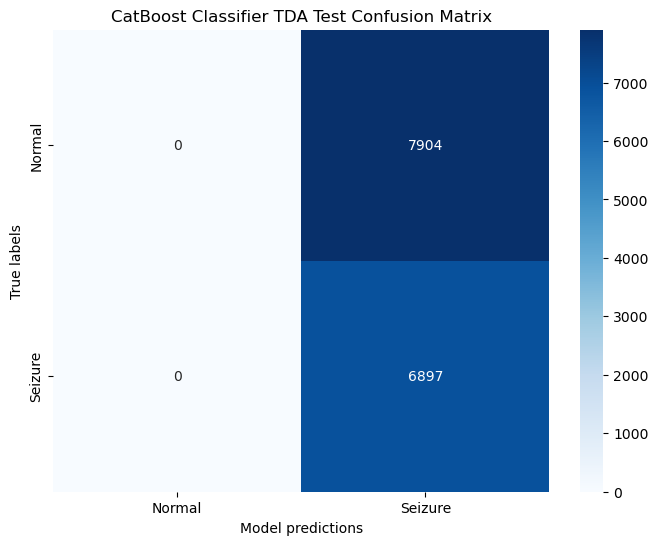

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: CatBoost Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for CatBoost Classifier...
    DEBUG: [CatBoost Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [CatBoost Classifier FFT] train_and_tune_model: Param grid: {'iterations': [100, 200], 'depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    DEBUG: [CatBoost Classifier FFT] train_and_tune_model: GridSearchCV cv=3, scoring

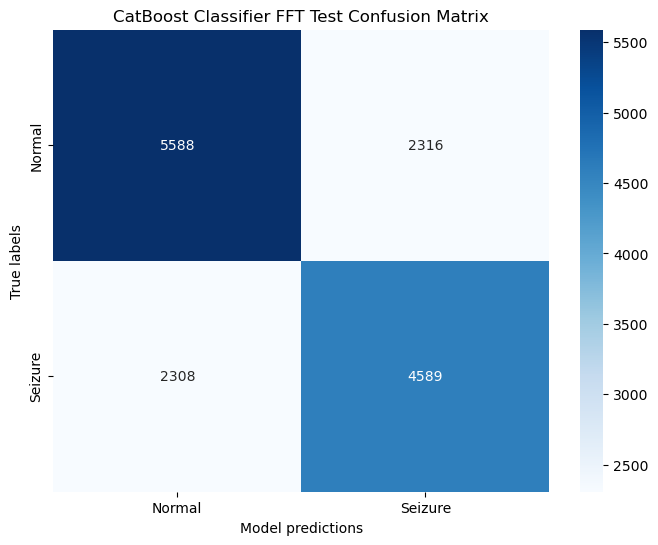

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR CatBoost Classifier COMPLETE.
############################################################


In [24]:
# ==============================================================================
# CELL 22: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the SGD classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================


import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---


# ===============================================
# Running the CatBoost Classifier
# ===============================================


model_to_run_name = "CatBoost Classifier"
model_to_run_fn = run_catboost_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name} (Noiseless Data)\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### KNN


############################################################
# STARTING EXPERIMENTS FOR: KNN Classifier (Noiseless Data)
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: KNN Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for KNN Classifier...
    DEBUG: [KNN Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [KNN Classifier Baseline] train_and_tune_model: Param grid: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    D

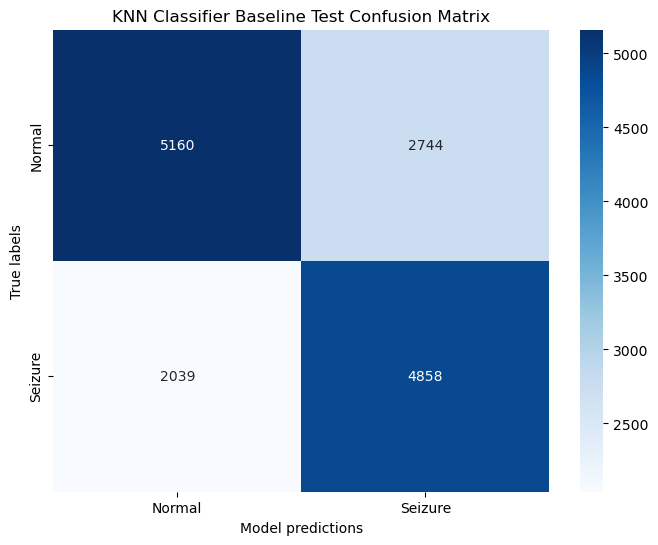

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: KNN Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for KNN Classifier...
    DEBUG: [KNN Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [KNN Classifier Wavelet] train_and_tune_model: Param grid: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    DEBUG: [KNN Classifier Wavelet] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted

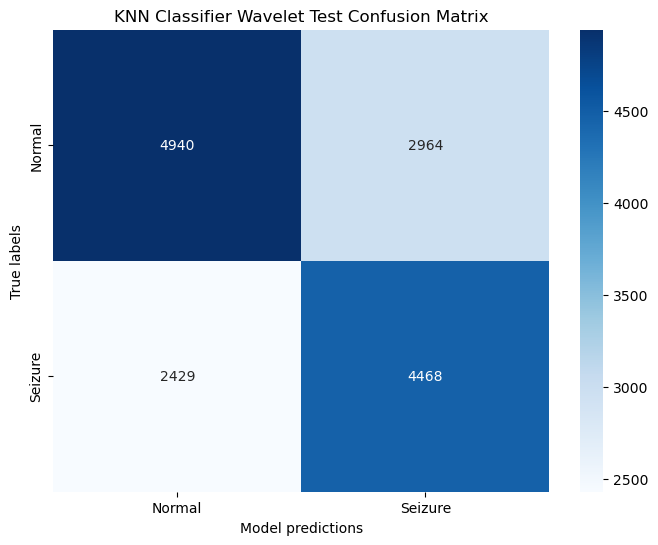

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: KNN Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for KNN Classifier...
    DEBUG: [KNN Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [KNN Classifier TDA] train_and_tune_model: Param grid: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    DEBUG: [KNN Classifier TDA] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs=1
    ---

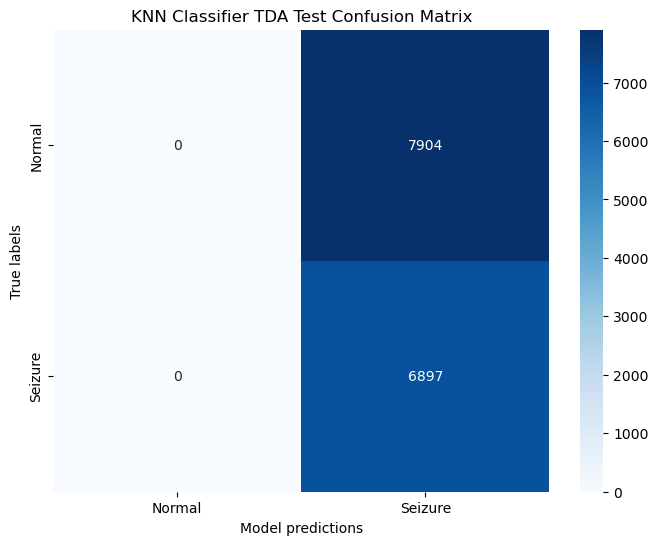

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: KNN Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for KNN Classifier...
    DEBUG: [KNN Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [KNN Classifier FFT] train_and_tune_model: Param grid: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    DEBUG: [KNN Classifier FFT] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs=1
    ---> [K

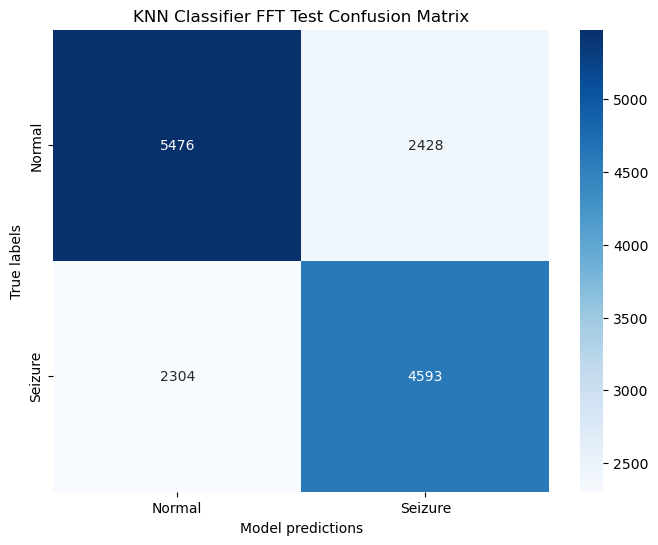

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR KNN Classifier COMPLETE.
############################################################


In [25]:
# ==============================================================================
# CELL 22: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================


import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---


# ===============================================
# Running the KNN Classifier
# ===============================================


model_to_run_name = "KNN Classifier"
model_to_run_fn = run_knn_classifier

print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name} (Noiseless Data)\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### MLP


############################################################
# STARTING EXPERIMENTS FOR: MLP Classifier (Noiseless Data)
############################################################

--- Loading CACHED Parquet data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.
    Shapes: X_train=(133209, 500), y_train=(133209,), X_test=(14801, 500), y_test=(14801,)

========================= RUNNING: MLP Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for MLP Classifier...
    DEBUG: [MLP Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [MLP Classifier Baseline] train_and_tune_model: Param grid: {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu', 't

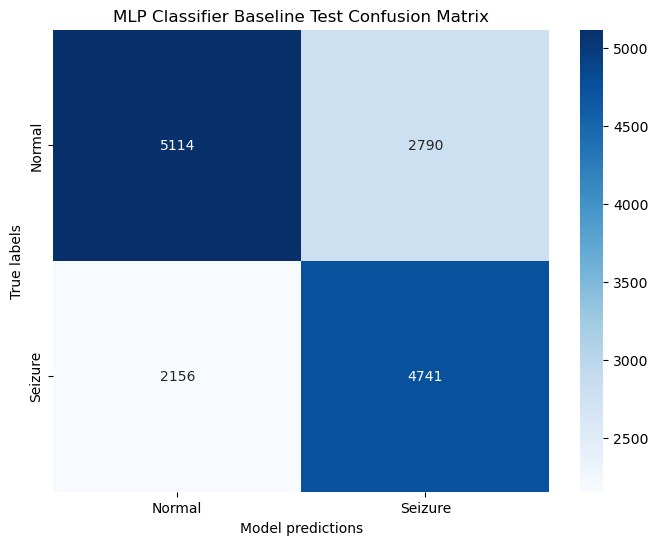

--- Clearing 'Baseline' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'Wavelet' features ---
  Successfully loaded 'Wavelet' data.
    Shapes: X_train=(133209, 36), y_train=(133209,), X_test=(14801, 36), y_test=(14801,)

========================= RUNNING: MLP Classifier on Wavelet Features =========================
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
  Starting model training and tuning for MLP Classifier...
    DEBUG: [MLP Classifier Wavelet] train_and_tune_model: X_train shape before GS.fit: (106567, 36), y_train shape: (106567,)
    DEBUG: [MLP Classifier Wavelet] train_and_tune_model: Param grid: {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]}
    DEBUG: [MLP Classifier Wavelet] train_and_tune_model: G

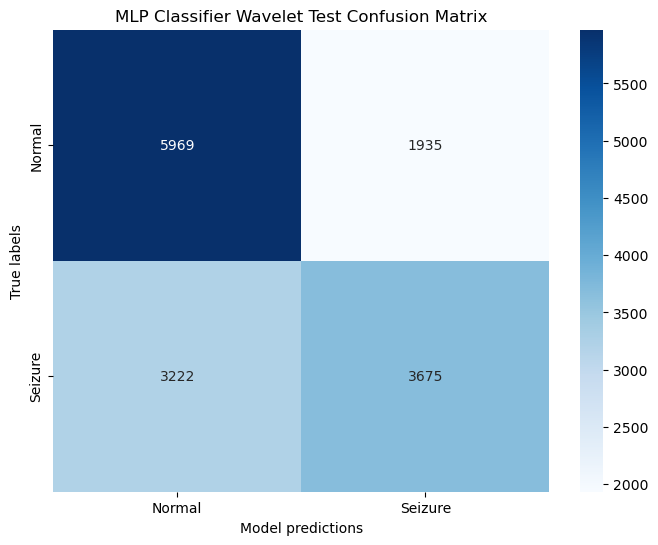

--- Clearing 'Wavelet' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'TDA' features ---
  Successfully loaded 'TDA' data.
    Shapes: X_train=(133209, 360), y_train=(133209,), X_test=(14801, 360), y_test=(14801,)

========================= RUNNING: MLP Classifier on TDA Features =========================
  Splitting full training data (X shape: (133209, 360), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 360)
    Validation set shape: (26642, 360)
  Starting model training and tuning for MLP Classifier...
    DEBUG: [MLP Classifier TDA] train_and_tune_model: X_train shape before GS.fit: (106567, 360), y_train shape: (106567,)
    DEBUG: [MLP Classifier TDA] train_and_tune_model: Param grid: {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]}
    DEBUG: [MLP Classifier TDA] train_and_tune_model: GridSearchCV cv=3, s

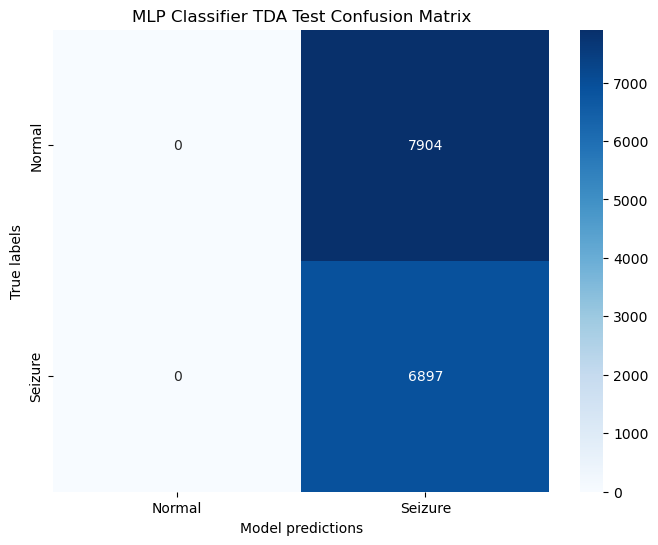

--- Clearing 'TDA' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


--- Loading CACHED Parquet data for 'FFT' features ---
  Successfully loaded 'FFT' data.
    Shapes: X_train=(133209, 250), y_train=(133209,), X_test=(14801, 250), y_test=(14801,)

========================= RUNNING: MLP Classifier on FFT Features =========================
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
  Starting model training and tuning for MLP Classifier...
    DEBUG: [MLP Classifier FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 250), y_train shape: (106567,)
    DEBUG: [MLP Classifier FFT] train_and_tune_model: Param grid: {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]}
    DEBUG: [MLP Classifier FFT] train_and_tune_model: GridSearchCV cv=3, scori

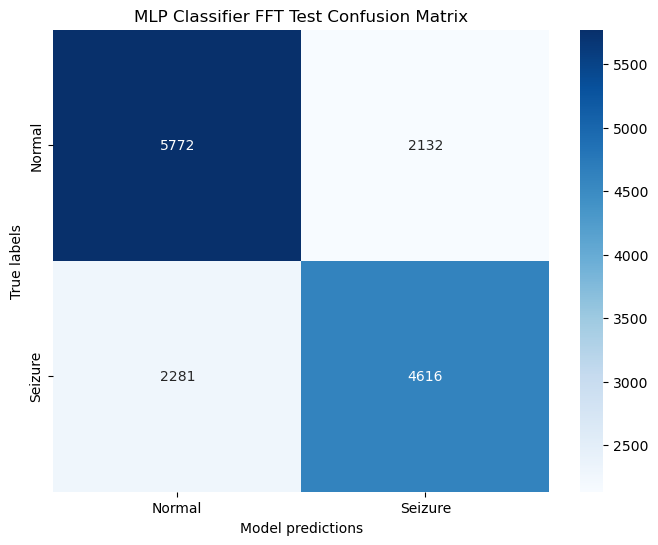

--- Clearing 'FFT' data from memory ---
--- Memory cleared. Proceeding to next feature set. ---


############################################################
# ALL EXPERIMENTS FOR MLP Classifier COMPLETE.
############################################################


In [26]:
# ==============================================================================
# CELL 23: REFACTORED MODEL TRAINING FROM PARQUET CACHE
# ==============================================================================
#
# PURPOSE:
# This cell runs the classifier on each of the pre-computed,
# cached feature sets. It loads one feature set at a time from the Parquet cache
# to maintain a low memory footprint.
#
# ==============================================================================


import pandas as pd
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
# Point to the directory where your Parquet feature files are stored
FEATURE_CACHE_DIR = "feature_cache_parquet"

# List of feature sets to iterate through for this model run.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}

# Import the necessary runner functions from your src modules.
# Note: run_logistic_regression now cleverly uses SGDClassifier for scalability.
from run_experiments import run_model_on_single_feature_set, run_logistic_regression

# --- 2. Main Training Loop for Logistic Regression ---


# ===============================================
# Running the MLP Classifier
# ===============================================


model_to_run_name = "MLP Classifier"
model_to_run_fn = run_mlp_classifier

print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name} (Noiseless Data)\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Parquet Cache ---
    print(f"\n--- Loading CACHED Parquet data for '{feature_name}' features ---")
    try:
        # Define the four file paths for the current feature set
        X_train_path = os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.parquet')
        y_train_path = os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.parquet')
        X_test_path = os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.parquet')
        y_test_path = os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.parquet')

        # Load from Parquet and convert to NumPy arrays
        X_train = pd.read_parquet(X_train_path).values
        y_train = pd.read_parquet(y_train_path).squeeze().values
        X_test = pd.read_parquet(X_test_path).values
        y_test = pd.read_parquet(y_test_path).squeeze().values
        
        print(f"  Successfully loaded '{feature_name}' data.")
        print(f"    Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
        
    except FileNotFoundError as e:
        print(f"  WARNING: Cached Parquet files for '{feature_name}' not found. Skipping this feature set. Error: {e}")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")

#### SVC 

#### DO NOT RUN THIS AS IT TAKES LOTS OF TIME FOR EVEN ONE FIT

In [24]:
#######
####### DO NOT RUN THIS
#######

import joblib
import os
import gc # Garbage Collector interface

# --- 1. Configuration ---
FEATURE_CACHE_DIR = "feature_cache"

# List of feature sets to iterate through. This controls which models are run.
# You can comment out lines here to quickly test on a subset of features.
feature_sets_to_run = ["Baseline", "Wavelet", "TDA", "FFT"]

# This should be defined in a previous cell, but we'll define it here for clarity
# if it's not already global.
CLASS_LABELS_BINARY_MAP = {0: 'Normal', 1: 'Seizure'}


# ===============================================
# Running the SVC Classifier
# ===============================================


model_to_run_name = "SVC Classifier"
model_to_run_fn = run_svc_classifier
print(f"\n{'#'*60}\n# STARTING EXPERIMENTS FOR: {model_to_run_name}\n{'#'*60}")

for feature_name in feature_sets_to_run:
    
    # --- a. Load ONE Feature Set from Cache ---
    print(f"\n--- Loading CACHED data for '{feature_name}' features ---")
    try:
        X_train = joblib.load(os.path.join(FEATURE_CACHE_DIR, f'X_train_{feature_name.lower()}.joblib'))
        y_train = joblib.load(os.path.join(FEATURE_CACHE_DIR, f'y_train_{feature_name.lower()}.joblib'))
        X_test = joblib.load(os.path.join(FEATURE_CACHE_DIR, f'X_test_{feature_name.lower()}.joblib'))
        y_test = joblib.load(os.path.join(FEATURE_CACHE_DIR, f'y_test_{feature_name.lower()}.joblib'))
        print(f"  Successfully loaded '{feature_name}' data.")
    except FileNotFoundError:
        print(f"  WARNING: Cached files for '{feature_name}' not found. Skipping this feature set.")
        continue # Move to the next feature set in the loop

    # --- b. Run the Model on this Single Feature Set ---
    try:
        run_model_on_single_feature_set(
            model_name=model_to_run_name,
            run_model_fn=model_to_run_fn,
            feature_name=feature_name,
            X_train_all=X_train,
            y_train_all=y_train,
            X_test=X_test,
            y_test=y_test,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"!! An error occurred while running {model_to_run_name} on {feature_name} features: {e}")
        import traceback
        traceback.print_exc()

    # --- c. Explicitly Release Memory ---
    print(f"--- Clearing '{feature_name}' data from memory ---")
    del X_train, y_train, X_test, y_test
    gc.collect() # Ask the garbage collector to run immediately.
    print("--- Memory cleared. Proceeding to next feature set. ---\n")

print(f"\n{'#'*60}\n# ALL EXPERIMENTS FOR {model_to_run_name} COMPLETE.\n{'#'*60}")



############################################################
# STARTING EXPERIMENTS FOR: SVC Classifier
############################################################

--- Loading CACHED data for 'Baseline' features ---
  Successfully loaded 'Baseline' data.

========================= RUNNING: SVC Classifier on Baseline Features =========================
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
  Starting model training and tuning for SVC Classifier...
    DEBUG: [SVC Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
    DEBUG: [SVC Classifier Baseline] train_and_tune_model: Param grid: {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    DEBUG: [SVC Classifier Baseline] train_and_tune_model: GridSearchCV cv=3, scoring='f1_weighted', n_jobs

KeyboardInterrupt: 

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH GAUSSIAN NOISE ADDED

### Noise Generation and Caching

 --- Technical Note on Noise Simulation Methodology ---

 The noise generation functions (`gaussian_noise`, `artifact_noise`) are designed to be
 applied to individual 1D time series arrays (i.e., rows in our DataFrame). In the main
 experimental workflow, this is achieved using `DataFrame.apply(noise_function, axis=1)`.

 Rationale for Row-Wise (`axis=1`) Application:

 1. Physical Realism: Each row in our dataset is an independent EEG recording segment.
    Real-world noise (e.g., sensor pops, muscle artifacts, environmental interference)
    is a phenomenon that corrupts a single recording over its duration. Therefore,
    simulated noise must be generated and applied independently for each row.

 2. Preservation of Signal Integrity: By operating row-wise, the noise characteristics
    are derived from the properties of that specific signal. For example, the standard
    deviation of Gaussian noise is scaled relative to the standard deviation of the
    individual 500-point signal it is being added to. This maintains a consistent
    Signal-to-Noise Ratio (SNR) relative to the signal's own amplitude.

 The Alternative (Column-Wise `axis=0`) is Incorrect Because:

 A column-wise application would treat each time point (e.g., column 'X10') as a
 feature vector across all unrelated samples. It would calculate a single noise value
 based on the statistics of that column and apply it. This wrongly assumes a
 statistical relationship between the 10th data point of Patient A's recording and
 the 10th data point of Patient B's recording. This breaks the temporal dependence
 within each signal and does not model any known physical noise process in EEG.

 Therefore, all noise simulations in this framework strictly adhere to a row-wise
 application model to ensure the validity of the subsequent robustness analysis.

**Noise configurations**

In [29]:
# ==============================================================================
# CELL 24: NOISE GENERATION AND CACHING
# ==============================================================================
#
# PURPOSE:
# This section systematically generates all required noisy datasets based on a
# centralized configuration. It applies realistic, well-defined noise models
# to the clean train and test data, then saves (caches) the resulting noisy
# DataFrames to disk using the efficient Parquet format.
#
# This "generate-once" approach ensures:
#   1. Reproducibility: The exact same noisy data is used for all subsequent steps.
#   2. Speed: Avoids re-running slow noise generation for every feature type
#      or model.
#   3. Clarity: All experimental noise conditions are defined in one place.
#
# ==============================================================================

import os
import pandas as pd
import numpy as np
import time

# --- 1. Import the Refactored Noise Functions ---
# It's good practice to import them here to ensure the correct versions are used.
try:
    from preprocessing import artifact_noise
    from feature_engineering import gaussian_noise
    print("Successfully imported noise generation functions.")
except ImportError:
    print("ERROR: Could not import `artifact_noise` or `gaussian_noise`.")
    print("Please ensure they are correctly defined in `preprocessing.py` and `feature_engineering.py` respectively,")
    print("and that your `../src` directory is in the system path.")
    raise

# --- 2. Configuration ---
# This is the central control panel for all noise experiments.
# To add a new experiment, simply add a new dictionary to this list.

# Define the sampling frequency of your AUBMC data
SAMPLING_FREQUENCY = 500

noise_configs = [
    # --- Gaussian Noise Configurations ---
    {'name': 'gaussian_snr20', 'type': 'gaussian', 'params': {'snr_db': 20}},
#    {'name': 'gaussian_snr10', 'type': 'gaussian', 'params': {'snr_db': 10}},
#    {'name': 'gaussian_snr0',  'type': 'gaussian', 'params': {'snr_db': 0}},
    
    # --- Spike Artifact Configuration ---
    # Corrupt 1% of the time points in each series with spikes.
    {'name': 'spike_1pct', 'type': 'spike', 'params': {'artifact_type': 'spike', 
                                                       'percentage': 0.01, 
                                                       'fs': SAMPLING_FREQUENCY}},
                                                       
    # --- Eyeblink Artifact Configuration ---
    # Add 2 distinct eyeblink events to each series.
    {'name': 'eyeblink_2', 'type': 'eyeblink', 'params': {'artifact_type': 'eyeblink', 
                                                          'percentage': 2, # Interpreted as 2 events
                                                          'fs': SAMPLING_FREQUENCY}}
]

# Define the directory where noisy DataFrames will be cached
NOISE_CACHE_DIR = "noisy_data_cache"
os.makedirs(NOISE_CACHE_DIR, exist_ok=True)

print(f"\nNoise configurations defined. Cached data will be stored in: '{NOISE_CACHE_DIR}/'")

# Check if the clean base DataFrames exist before starting
if 'df_train_full' not in locals() or 'df_test_full' not in locals():
    raise NameError("Clean DataFrames `df_train_full` and `df_test_full` not found. Please load them first.")
if 'predictors' not in locals():
    raise NameError("`predictors` list (e.g., ['X1', ..., 'X500']) not found.")


# --- 3. Caching Loop ---
# This loop iterates through each configuration, creates the noisy data, and saves it.

for config in noise_configs:
    config_name = config['name']
    print(f"\n{'='*25} PROCESSING NOISE CONFIG: {config_name.upper()} {'='*25}")
    
    # Define file paths for the cached noisy data
    train_output_path = os.path.join(NOISE_CACHE_DIR, f'df_train_{config_name}.parquet')
    test_output_path = os.path.join(NOISE_CACHE_DIR, f'df_test_{config_name}.parquet')
    
    # Check if this noisy dataset has already been cached
    if os.path.exists(train_output_path) and os.path.exists(test_output_path):
        print(f"  -> Cached files already exist for '{config_name}'. Skipping generation.")
        continue

    # --- Select the appropriate noise function ---
    if config['type'] == 'gaussian':
        # The lambda function captures the correct function and its parameters for later use
        noise_function = lambda series: gaussian_noise(series, **config['params'])
    elif config['type'] in ['spike', 'eyeblink', 'missing', 'stuck', 'step', 'line']:
        noise_function = lambda series: artifact_noise(series, **config['params'])
    else:
        print(f"  WARNING: Unknown noise type '{config['type']}' in config. Skipping.")
        continue
        
    # --- Generate and Save Noisy Training Data ---
    print(f"  Generating noisy TRAINING data for '{config_name}'...")
    start_time_train = time.time()
    
    # Create a copy to modify
    df_train_noisy = df_train_full.copy()
    
    # Apply the noise function row-by-row to the predictor columns
    noisy_predictors_series = df_train_noisy[predictors].apply(noise_function, axis=1)
    
    # =================================================================================
    # === THE FIX: Convert the result of .apply() back to a DataFrame explicitly ===
    # The result of `apply` is a Series of arrays. `list(noisy_predictors_series)`
    # converts this to a list of arrays, which pd.DataFrame handles correctly.
    noisy_predictors_train_df = pd.DataFrame(
        list(noisy_predictors_series), 
        columns=predictors, 
        index=df_train_noisy.index
    )
    # =================================================================================
    
    # Update the columns in the DataFrame with the new noisy data
    df_train_noisy[predictors] = noisy_predictors_train_df
    
    # Save the resulting DataFrame to a Parquet file
    df_train_noisy.to_parquet(train_output_path)
    
    end_time_train = time.time()
    print(f"  -> Finished in {end_time_train - start_time_train:.2f} seconds.")
    print(f"     Saved noisy training data to: {train_output_path}")

    # --- Generate and Save Noisy Test Data ---
    print(f"  Generating noisy TEST data for '{config_name}'...")
    start_time_test = time.time()
    
    df_test_noisy = df_test_full.copy()
    noisy_predictors_series_test = df_test_noisy[predictors].apply(noise_function, axis=1)
    
    # =================================================================================
    # === APPLY THE SAME FIX for the test set ===
    noisy_predictors_test_df = pd.DataFrame(
        list(noisy_predictors_series_test),
        columns=predictors,
        index=df_test_noisy.index
    )
    # =================================================================================

    df_test_noisy[predictors] = noisy_predictors_test_df
    df_test_noisy.to_parquet(test_output_path)
    
    end_time_test = time.time()
    print(f"  -> Finished in {end_time_test - start_time_test:.2f} seconds.")
    print(f"     Saved noisy test data to: {test_output_path}")

    # Clean up memory before the next iteration
    del df_train_noisy, df_test_noisy, noisy_predictors_series, noisy_predictors_train_df, noisy_predictors_series_test, noisy_predictors_test_df
    
print("\n\n--- Noise Generation and Caching Complete ---")

Successfully imported noise generation functions.

Noise configurations defined. Cached data will be stored in: 'noisy_data_cache/'

========================= PROCESSING NOISE CONFIG: GAUSSIAN_SNR20 =========================
  Generating noisy TRAINING data for 'gaussian_snr20'...
  -> Finished in 27.48 seconds.
     Saved noisy training data to: noisy_data_cache/df_train_gaussian_snr20.parquet
  Generating noisy TEST data for 'gaussian_snr20'...
  -> Finished in 2.43 seconds.
     Saved noisy test data to: noisy_data_cache/df_test_gaussian_snr20.parquet

========================= PROCESSING NOISE CONFIG: SPIKE_1PCT =========================
  Generating noisy TRAINING data for 'spike_1pct'...
  -> Finished in 30.88 seconds.
     Saved noisy training data to: noisy_data_cache/df_train_spike_1pct.parquet
  Generating noisy TEST data for 'spike_1pct'...
  -> Finished in 3.29 seconds.
     Saved noisy test data to: noisy_data_cache/df_test_spike_1pct.parquet

========================= PRO

In [ ]:
df_viz_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_viz_gaussian[feature_cols] = df_viz_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_viz_gaussian['y'] = df_viz_gaussian['y'].map(class_labels)
X_viz_gaussian = normalize_data(df_viz_gaussian, predictors)  
y_viz_gaussian, _ =  get_features_and_labels(data)  
plot_class_signals(X_viz_gaussian, y_viz_gaussian)

In [ ]:
df_train_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_train_gaussian[feature_cols] = df_train_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_train_gaussian[predictors] = normalize_data(df_train_gaussian, predictors)

## Bottleneck distance (h1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_gaussian, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")

In [ ]:
plot_persistence_diagrams_from_data(df_train_gaussian, "gaussian_noise_data")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_gaussian)
plot_persistence_images(labels, persistence_images_noisy, "gaussian noisy data")


#### KNN (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "KNN Classifier", run_knn_classifier)

#### Random Forest (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "Random Forest Classifier", run_random_forest_classifier)

#### XGBoost (Noisy Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_gaussian)
run_model_fft_xgboost(df_train_gaussian)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH ARTIFACT NOISE ADDED

### Spike noise

In [ ]:
df_viz_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_viz_spike[col] = artifact_noise(df_viz_spike[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.99)  
df_viz_spike['y'] = df_viz_spike['y'].map(class_labels) 
X_viz_spike = normalize_data(df_viz_spike, predictors)
y_viz_spike, _ =  get_features_and_labels(data)  

In [ ]:
plot_class_signals(X_viz_spike, y_viz_spike)

In [ ]:
df_train_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

# Add different types of artifacts to different columns
for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_train_spike[col] = artifact_noise(df_train_spike[col], 
                                   artifact_type='spike',
                                   percentage=0.99)  # 99% of points affected

df_train_spike[feature_cols] = normalize_data(df_train_spike, feature_cols)




## Bottleneck Distance (H1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_spike, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")


In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")


### Visualize the Persistence Images of the Artifact Noise Data

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_spike)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")


### Visualize the persistence diagrams of the Artifact noise data

In [ ]:
plot_persistence_diagrams_from_data(df_train_spike, "eyeblink_noise_data")

#### KNN (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "KNN Classifier", run_knn_classifier)

#### Random Forest (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "Random Forest Classifier", run_random_forest_classifier)

#### CatBoost (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "CatBoost Classifier", run_catboost_classifier)

#### XGBoost (Artifact Noise Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_spike)
run_model_fft_xgboost(df_train_spike)

### Try with eyeblink

In [ ]:
df_viz_eyeblink = data.copy()
feature_cols = [x for x in df_viz_eyeblink.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'eyeblink'
    df_viz_eyeblink[col] = artifact_noise(df_viz_eyeblink[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.1)  
df_viz_eyeblink['y'] = df_viz_eyeblink['y'].map(class_labels) 
X_viz_eyeblink = normalize_data(df_viz_eyeblink, predictors)
y_viz_eyeblink, _ =  get_features_and_labels(df_viz_eyeblink)  

In [ ]:
df_train_eyeblink = data.copy()
df_train_eyeblink['Unnamed'] = data['Unnamed']  # if needed

feature_cols = [x for x in df_train_eyeblink.columns if x.startswith('X')]

for col in feature_cols:
    df_train_eyeblink[col] = artifact_noise(df_train_eyeblink[col], artifact_type='eyeblink', percentage=0.99)

df_train_eyeblink[feature_cols] = normalize_data(df_train_eyeblink, feature_cols)

## Bottleneck Distance

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_eyeblink, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
target_class = 'seizure activity'
within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{target_class}': {within_dist:.4f}")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_eyeblink)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")

In [ ]:
plot_persistence_diagrams_from_data(df_train_eyeblink, "eyeblink_noise_data")

In [ ]:
run_model_on_features(df_train_eyeblink, "KNN Classifier", run_knn_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "Random Forest Classifier", run_random_forest_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "CatBoost Classifier", run_catboost_classifier)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_eyeblink )
run_model_fft_xgboost(df_train_eyeblink )

## Show Results

### Full Table of Results

In [ ]:
from metrics import load_and_group_metrics, print_metrics_summary, print_model_deltas, print_model_deltas_noisy2
metrics = load_and_group_metrics("metrics")

for ftype, df in metrics.items():
    print(f"\n=== {ftype} Features Metrics Summary ===")
    print(df.to_string())


In [ ]:
print_metrics_summary("metrics")

In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)


In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)

In [ ]:
#for model in models:
 #   plot_model_absolute_bars(model)

In [ ]:
models = [ 'CatBoost', 'KNN', 'Random Forest', 'XGBoost']
for model in models:
    result = print_model_deltas_noisy2(model)
    result.to_csv(f"metrics/{model}_deltas_noisy.csv", index=False)